# Continuous Assessment 1


Using the Boston data set introduced during LAB work, apply linear regression modelling to predict the per capita crime rate using other variables in the data set. In other words, per capita crime rate is the response and the other variables are predictors.


# Additional Libraries and Tools


### [Github Repo](https://github.com/Ri-Dearg/data-analytics-dbs/)

This file and its commit history [can be found by clicking here](https://github.com/Ri-Dearg/data-analytics-dbs/blob/main/statistics/ca1-boston-data/ca1.ipynb).

### [Matplotlib ](https://matplotlib.org)

For creating plots and visualising data.

### [Numpy](https://numpy.org)

For scientific computing.

### [Pandas](https://pandas.pydata.org)

For data analysis and manipulation.

### [Seaborn](https://seaborn.pydata.org)

For data visualisation.

### [Scipy](https://scipy.org)

For t-tests.

### [Scikit-learn](https://scikit-learn.org/stable/)

For polynomial regression.

### [Statsmodels](https://www.statsmodels.org/stable/index.html)

For statistical exploration.

### [Pylint](https://www.pylint.org)

Used as a linter for code quality control.

### [Ruff](https://docs.astral.sh/ruff/)

Used as both a linter and a formatter. Configuration has been adjusted to conform to PEP8 standard.

### References

- Identifying and winsorising outliers:
  - https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0/
  - https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/


In [195]:
# Import necessary libraries
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.api import OLS
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reorder colour palette to light blue as the dark blue is harder to read.
def_palette = sns.color_palette('deep')
reordered_palette = [def_palette[i] for i in [9, 1, 2, 3, 4, 5, 6, 7, 8, 0]]
sns.set_palette(reordered_palette)


# Utilities

Functions used so as to not repeat code. One for plotting grids, the other to winsorize outliers.


In [196]:
# Callable function to create plots
def multi_row_plot(
    seaborn_func: object,
    data: object,
    grid: tuple = (4, 4),
    size: tuple = (25, 20),
    *,
    y_col: bool = False,
    **kwargs: dict[str, Any],
) -> None:
    """Create a plot with default values.

    Args:
        seaborn_func (object): seaborn plot function to run.
        data (object): _description_
        grid (tuple, optional): Rows and columns. Defaults to (2, 7).
        size (tuple, optional): Width and Height. Defaults to (32, 7).
        y_col(None, optional): x axis if doing a correlation plot.
        **kwargs(dict, optional): keyword for the seaborn function

    """
    data_cols = data.columns

    # Structure plots to easily fit the data.
    fig_plot, axes = plt.subplots(grid[0], grid[1], figsize=(size[0], size[1]))
    # Flatten axes so it is easier to enumerate.
    axes = axes.flatten()
    # Cheks to see if it is a correlation plot.
    if y_col is True:
        for i, item in enumerate(data_cols[1:]):
            seaborn_func(data=data, x=item, y='CRIM', ax=axes[i], **kwargs)
    # Runs single predictor plot if not.
    else:
        for i, item in enumerate(data_cols):
            seaborn_func(data=data, x=item, ax=axes[i], **kwargs)

    # Hide any unused subplots.
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')


def winsorize_outliers(data_orig: object, data_win: object, col: str) -> None:
    """Find and clip outliers from the dataset.

    Args:
        data_orig (object): Original dataset.
        data_win (object): Copy of dataset.
        col (str): The name of the col to check.

    """
    # Find Quartile Ranges
    quart1 = data_orig[col].quantile(0.25)
    quart3 = data_orig[col].quantile(0.75)
    inter_quart = quart3 - quart1
    lower_bound = quart1 - 1.5 * inter_quart
    upper_bound = quart3 + 1.5 * inter_quart

    # Only clip the outliers
    data_win[col] = np.where(
        data_orig[col] < lower_bound,
        lower_bound,
        np.where(data_orig[col] > upper_bound, upper_bound, data_orig[col]),
    )


def create_mlr_model(data: object, drop_predictors: list) -> object:
    """Create a multiple Linear Regression model.

    Args:
        data (object): The data frame to analyse.
        drop_predictors (list): Columns to drop.

    Returns:
        object: The OLS MLR model.

    """
    # Drop predictors from the data set.
    predictors = data.columns.drop(drop_predictors).tolist()

    # Create a formula to include the predictors.
    formula = f'CRIM~{"+".join(predictors)}'

    # Fit the model.
    model = ols(formula, data).fit()
    # Display standard error.
    print('Residual Standard Error is ', np.sqrt(model.mse_resid))
    return model

# Descriptive Analysis

## a) Use descriptive statistics to explore the dataset.


First I will check the data types for the set and then check for missing or invalid values.


In [197]:
# Access CSV file.
boston_csv = pd.read_csv('boston-data.csv')

In [198]:
# Display and read data info and type.
boston_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CRIM    506 non-null    float64
 1   ZN      506 non-null    float64
 2   INDUS   506 non-null    float64
 3   CHAS    506 non-null    int64  
 4   NOX     506 non-null    float64
 5   RM      506 non-null    float64
 6   AGE     506 non-null    float64
 7   DIS     506 non-null    float64
 8   RAD     506 non-null    int64  
 9   TAX     506 non-null    int64  
 10  PT      506 non-null    float64
 11  B       506 non-null    float64
 12  LSTAT   506 non-null    float64
 13  MV      506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [199]:
# Sum any missing values.
boston_csv.isna().sum()

CRIM     0
ZN       0
INDUS    0
CHAS     0
NOX      0
RM       0
AGE      0
DIS      0
RAD      0
TAX      0
PT       0
B        0
LSTAT    0
MV       0
dtype: int64

Examine the general statistics of each item in the data set.


In [200]:
# Use describe to view summary statistics for each variable.
boston_csv.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976196  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX          PT           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674030   
std     28.148862    2.105710    8.707259  168.537116    2.164946   91.294863   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377487   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440002   
75%     94.074999    5.188425   24.000000  666.000000   20.200001  396.225006   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.899994   

            LSTAT          MV  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200001  
75%     16.954999   25.000000  
max     37.970001   50.000000

Create box plots to identify outliers.


In [ ]:
# Structure plots to easily fit the data.
multi_row_plot(sns.boxplot, boston_csv)


Clean outliers from relevant data. I have chosen to winsorize the outliers. I have not altered the "CHAS" column, as that is a dummy value for a categorical value, it is certain there are no outliers for that data.


In [ ]:
# Create a deep copy as to not alter the original dataset.
boston_win = boston_csv.copy(deep=True)

In [ ]:
# Winsorize the data
for col in boston_csv.columns:
    # Skip CHAS column
    if col == 'CHAS':
        continue
    winsorize_outliers(boston_csv, boston_win, col)

In [ ]:
# Show the general statistics after winsorization.
boston_win.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     2.225032    6.963439   11.136779    0.069170    0.554695    6.275312   
std      3.313353   12.028788    6.860353    0.253994    0.115878    0.630242   
min      0.006320    0.000000    0.460000    0.000000    0.385000    4.778500   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max      9.069639   31.250000   27.740000    1.000000    0.871000    7.730500   

              AGE         DIS         RAD         TAX          PT           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.783947    9.549407  408.237154   18.463834  381.918828   
std     28.148862    2.069765    8.707259  168.537116    2.143925   19.054924   
min      2.900000    1.129600    1.000000  187.000000   13.199998  344.106209   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377487   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440002   
75%     94.074999    5.188425   24.000000  666.000000   20.200001  396.225006   
max    100.000000    9.820801   24.000000  711.000000   22.000000  396.899994   

            LSTAT          MV  
count  506.000000  506.000000  
mean    12.612011   21.877075  
std      7.016829    7.602976  
min      1.730000    5.062500  
25%      6.950000   17.025000  
50%     11.360000   21.200001  
75%     16.954999   25.000000  
max     31.962499   36.962500

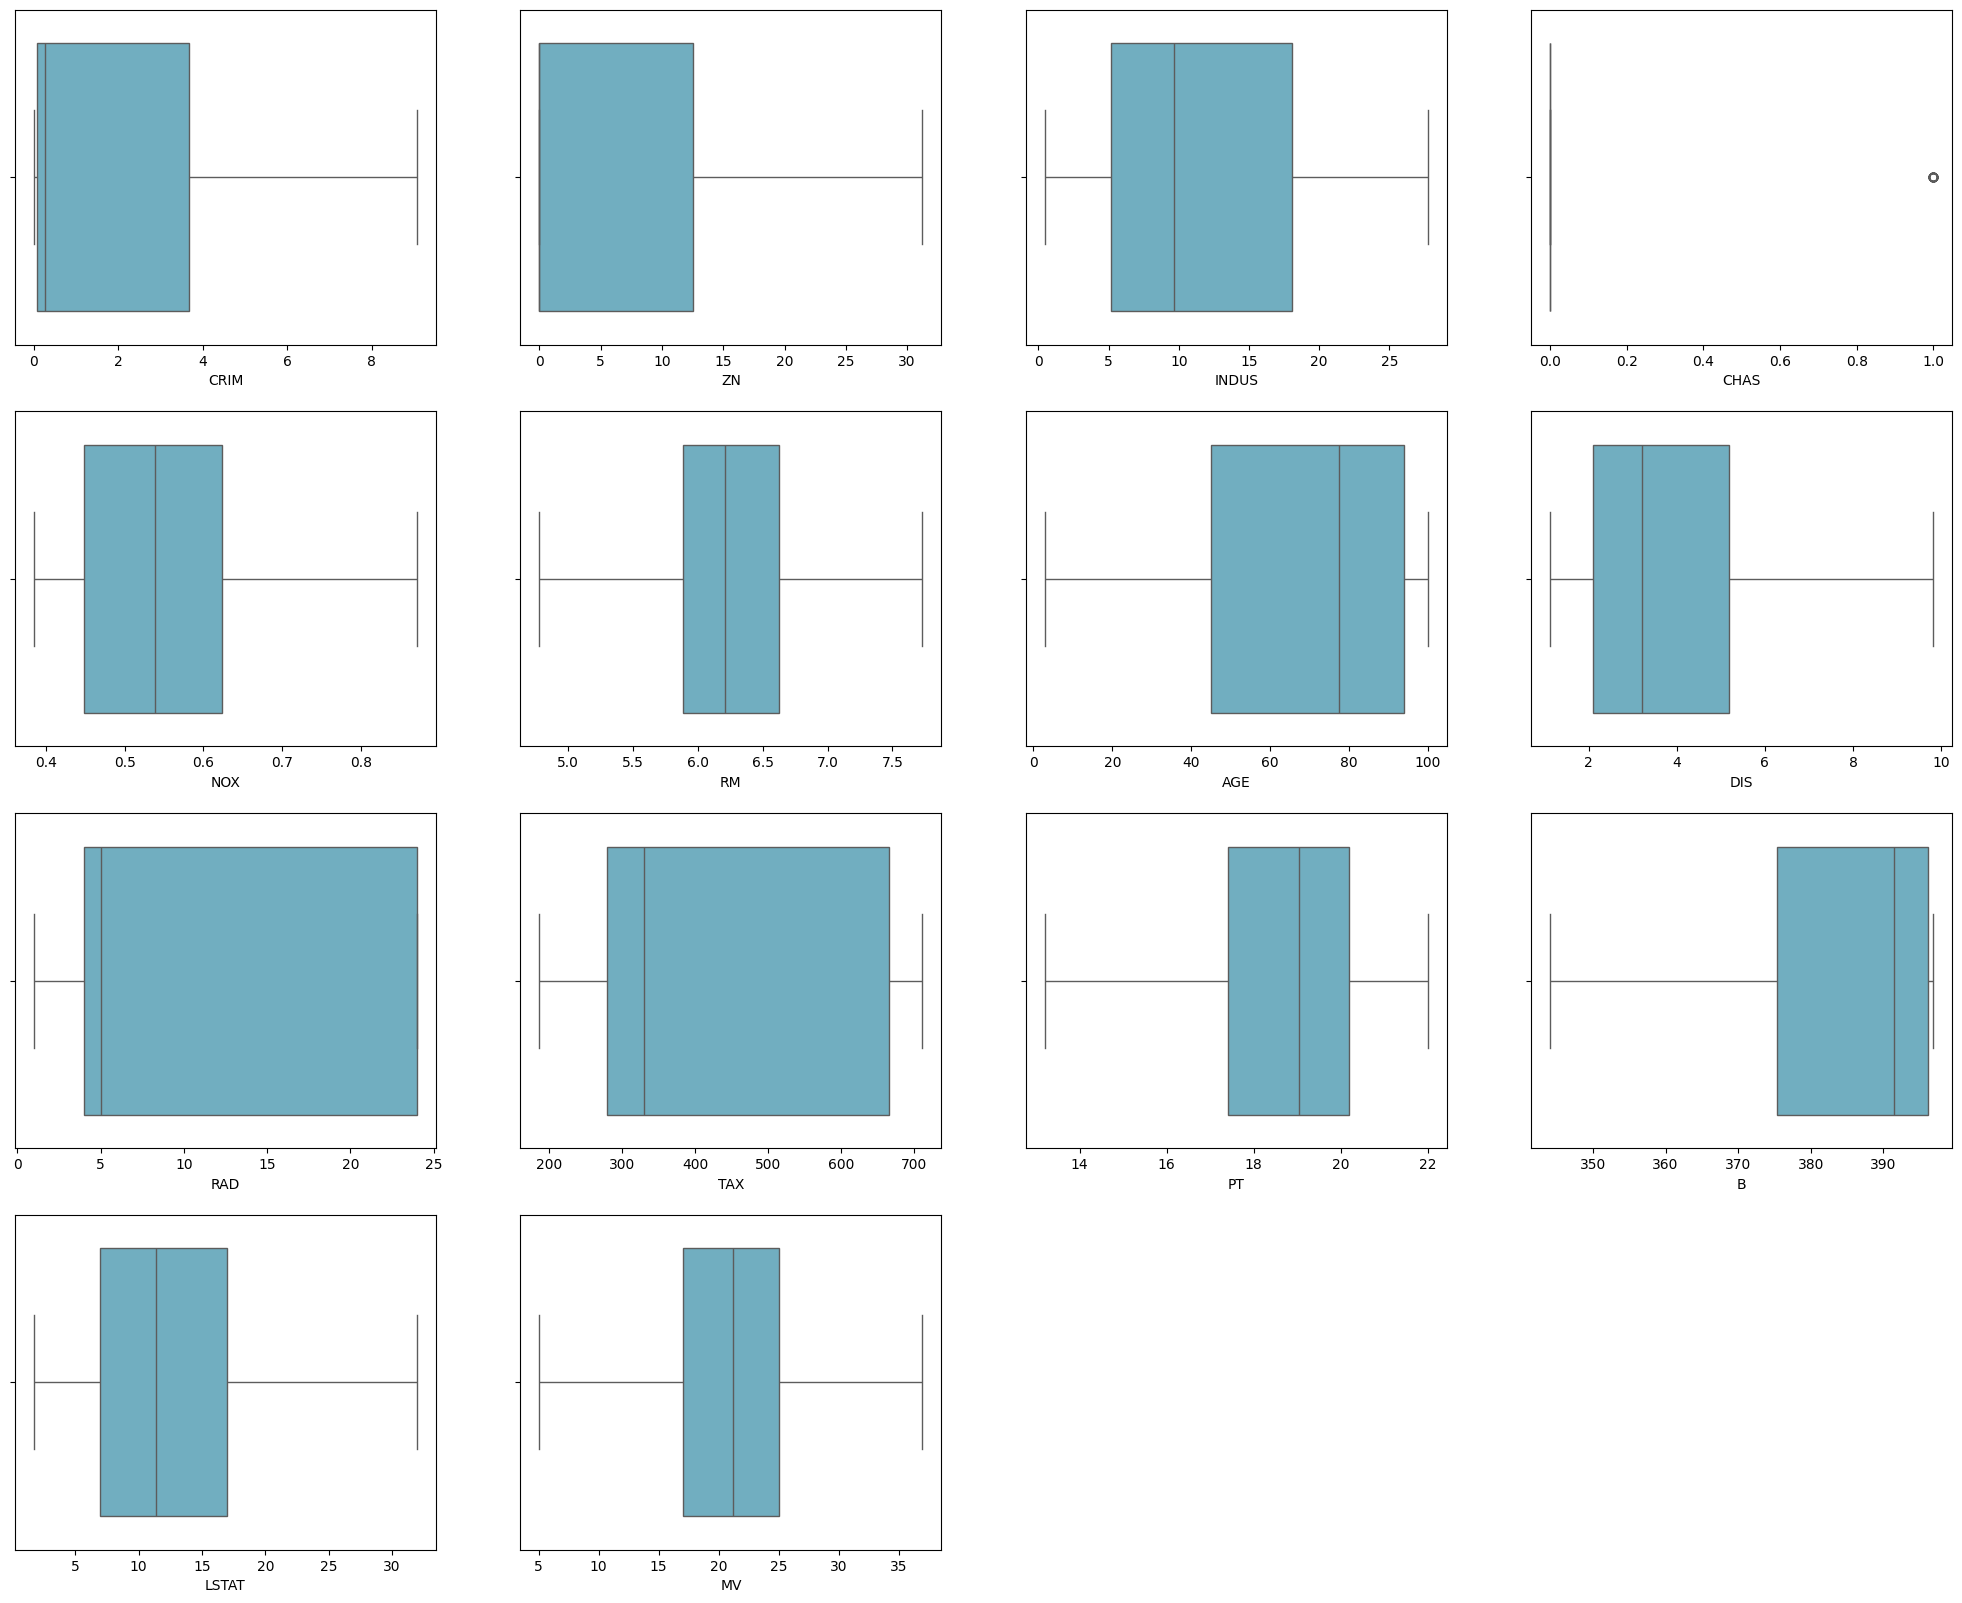

In [ ]:
# Display the box plots without outliers.
multi_row_plot(sns.boxplot, boston_win)

Plot histograms to see the distribution of the data. Here you can see the histograms before and after cleaning of the data.


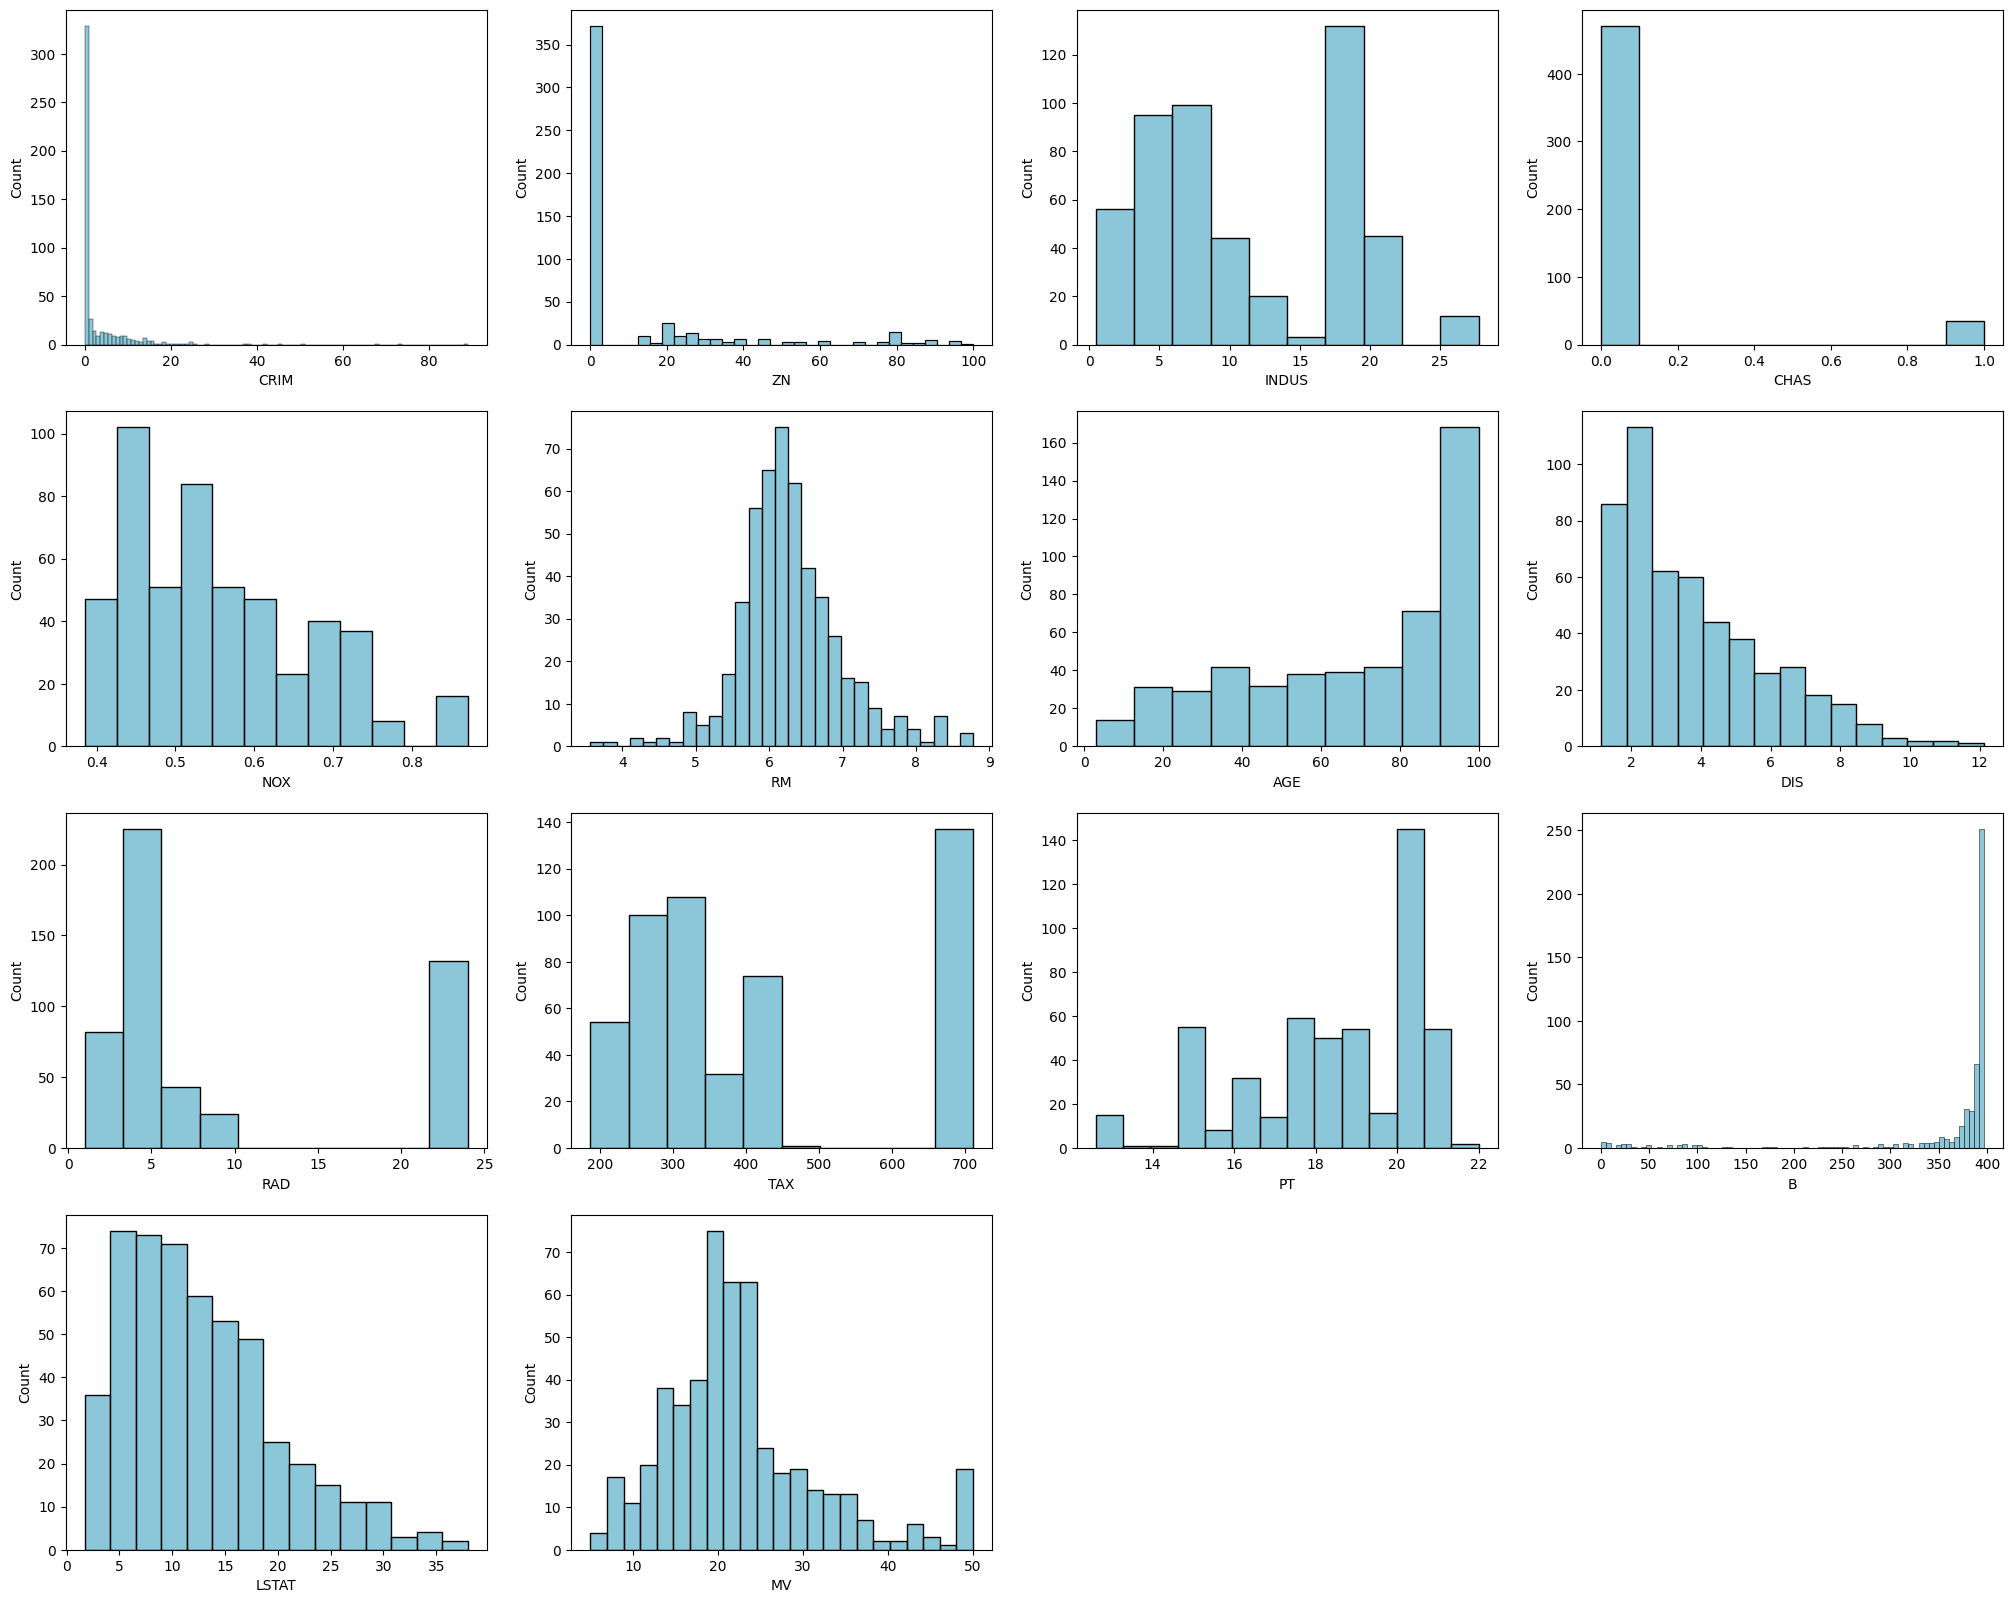

In [ ]:
# Before data cleaning
multi_row_plot(sns.histplot, boston_csv)

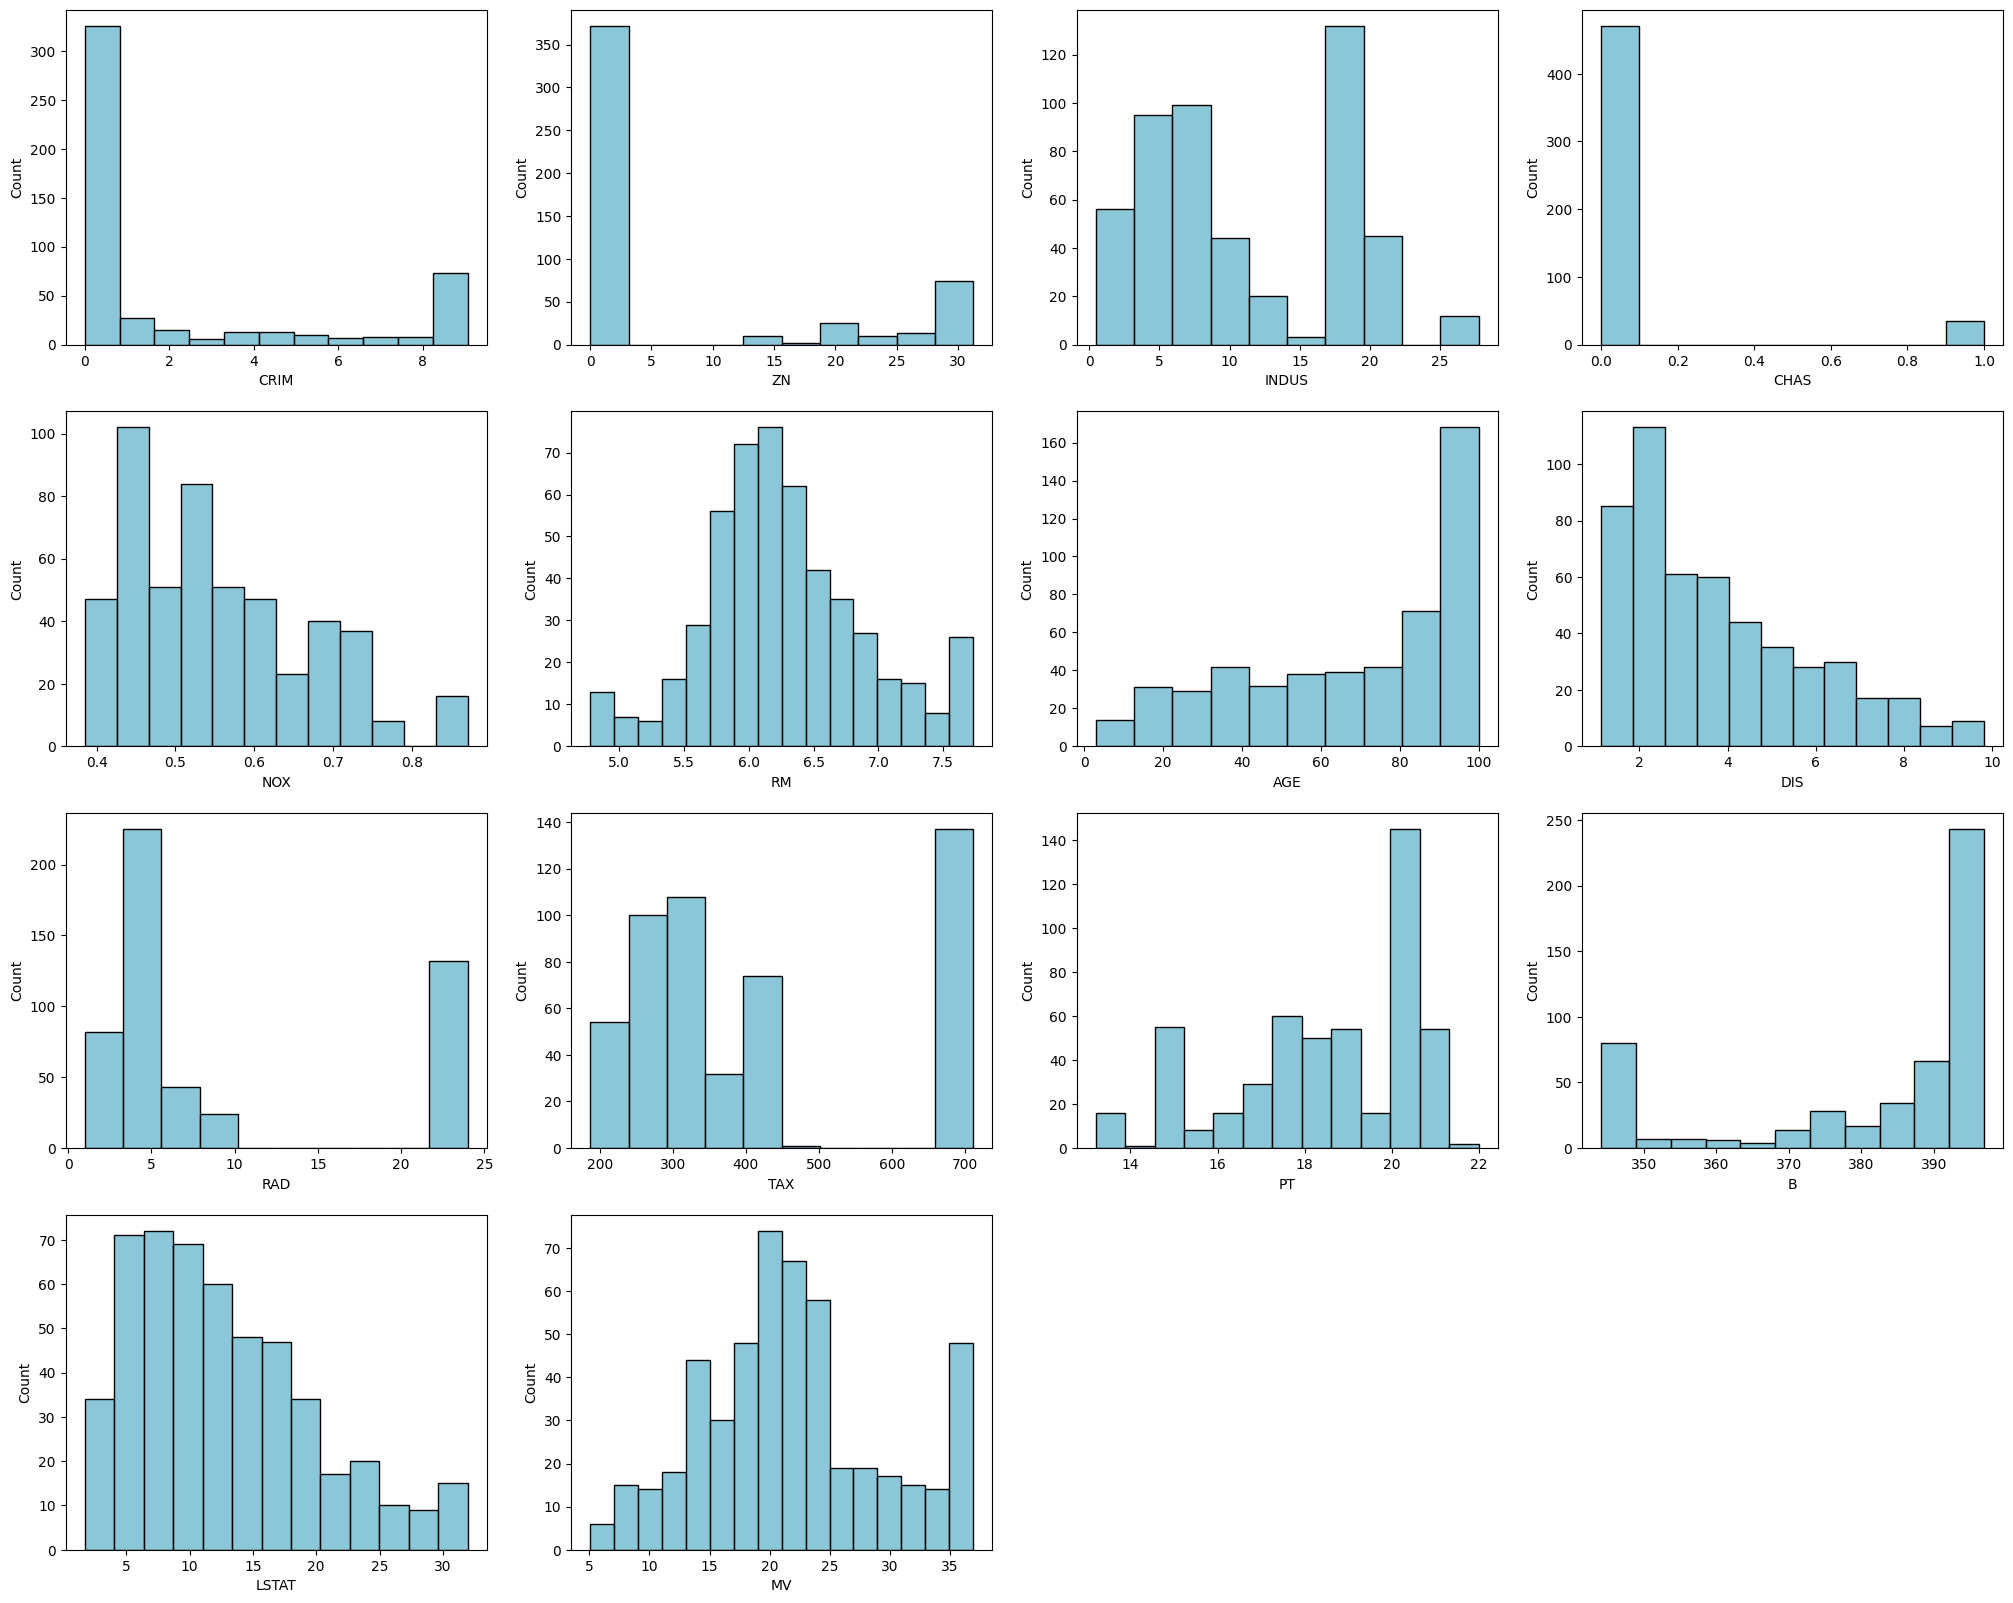

In [ ]:
# Structure plots after data cleaning.
multi_row_plot(sns.histplot, boston_win)

Add violin plots to show median, interquartile range, concentration of values and distribution.


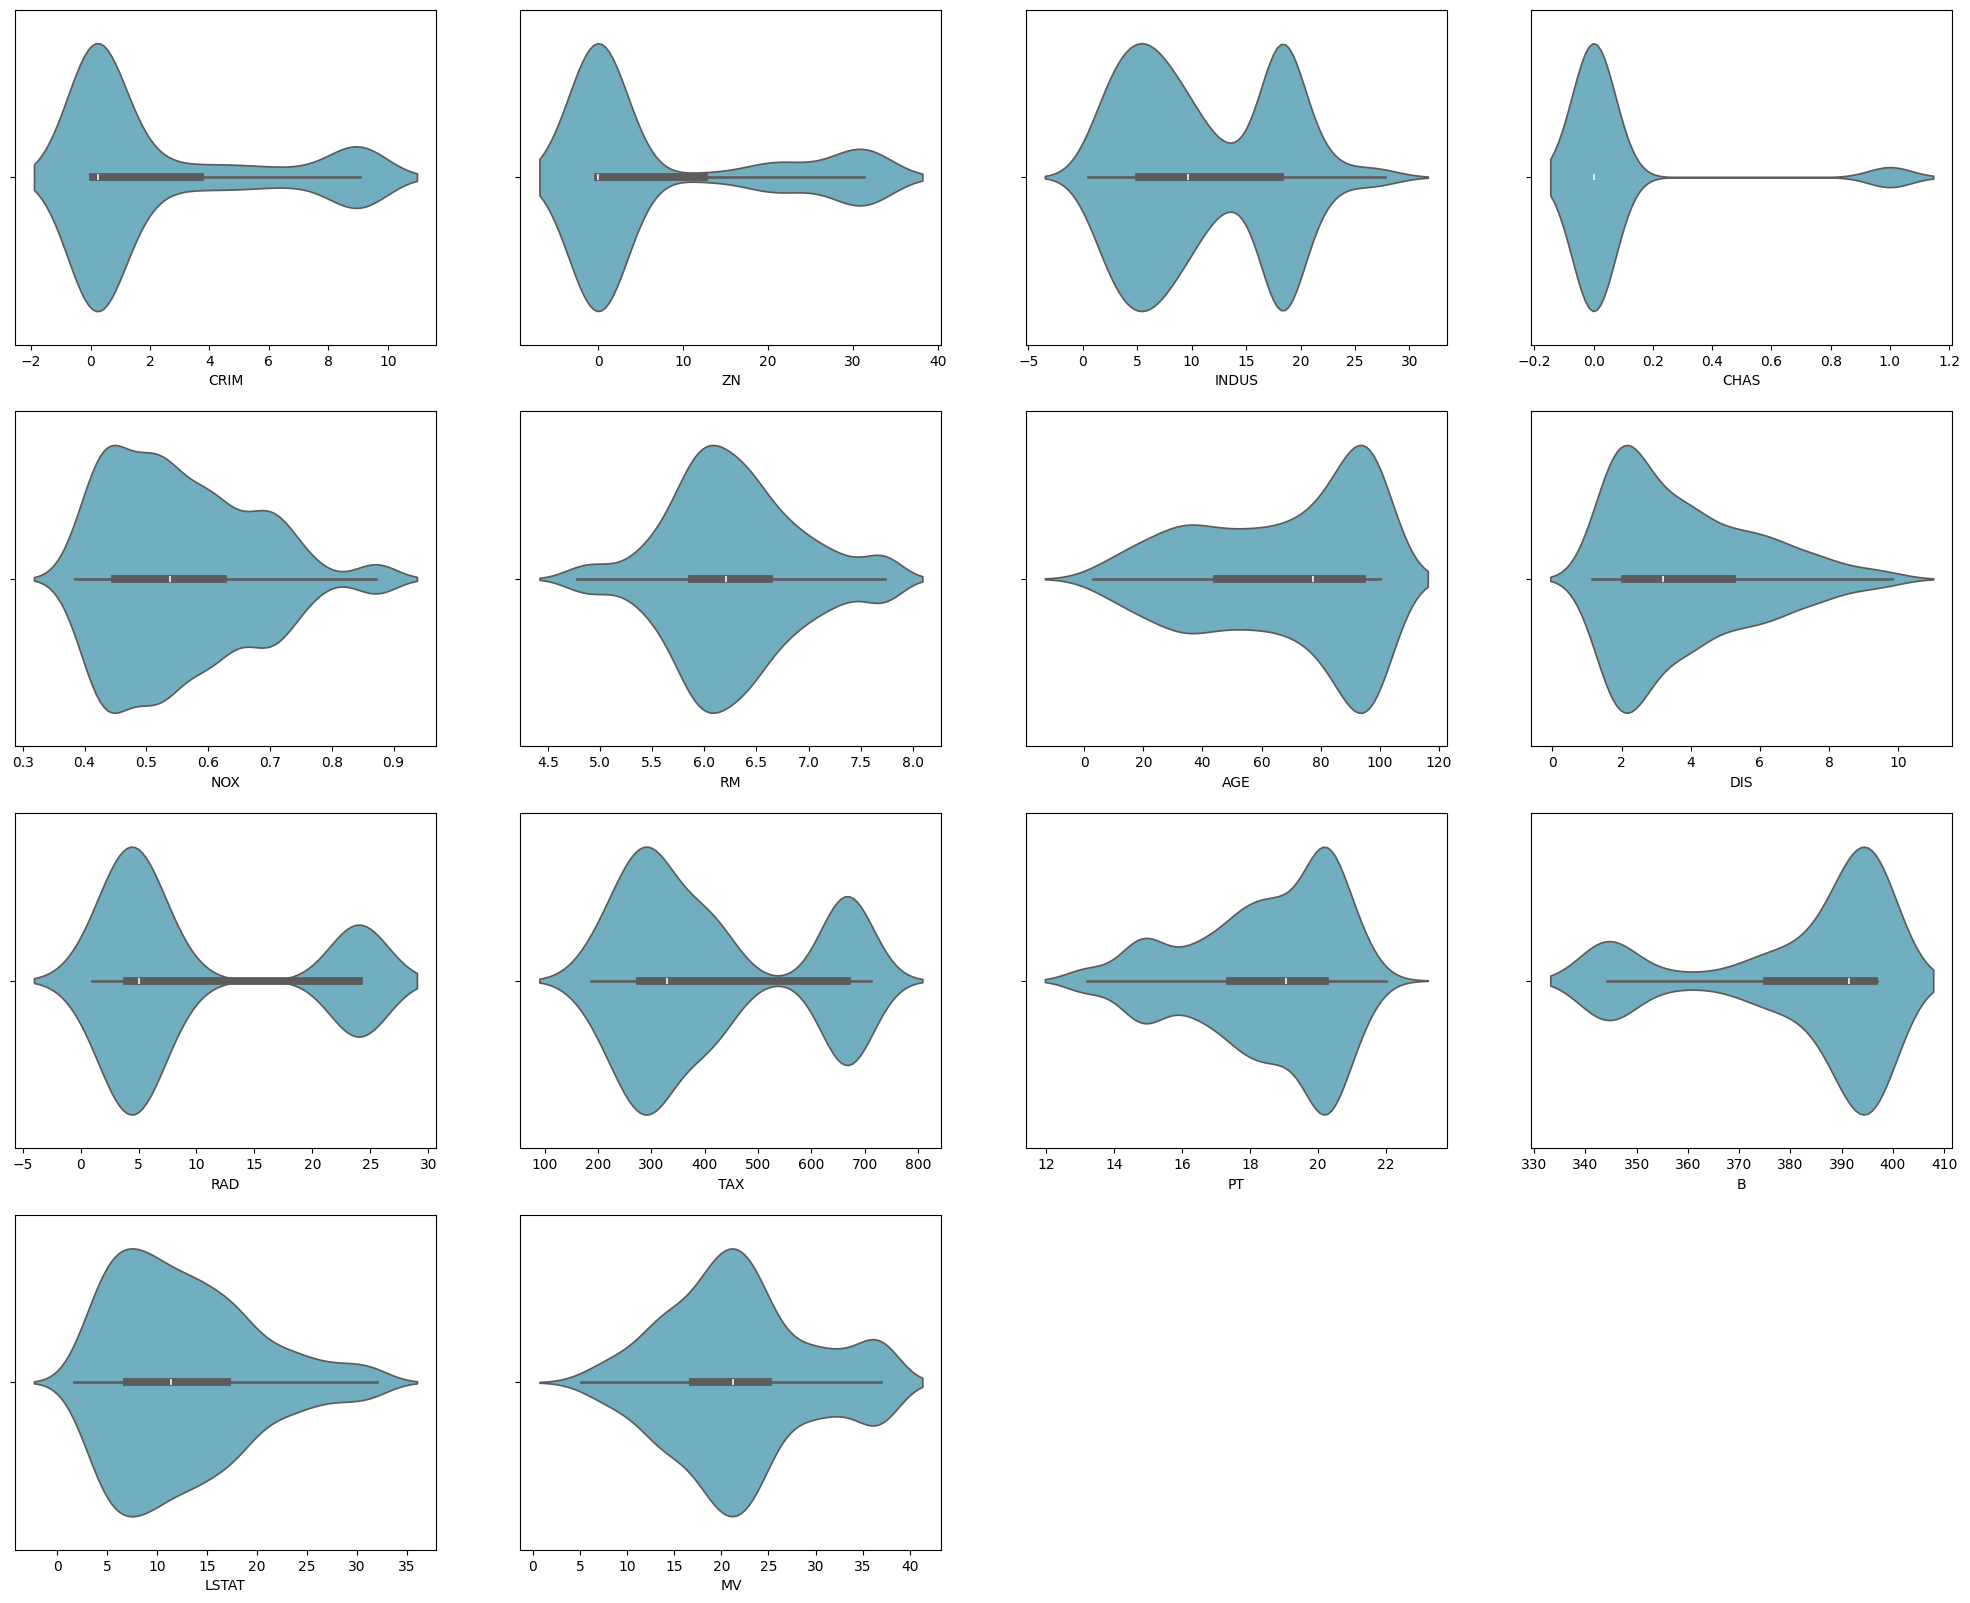

In [ ]:
multi_row_plot(sns.violinplot, boston_win)

Finally, as CHAS is categorical data, I will compare the two CHAS values to see if there is any significant statistical difference. If there is, they should be analysed separately.


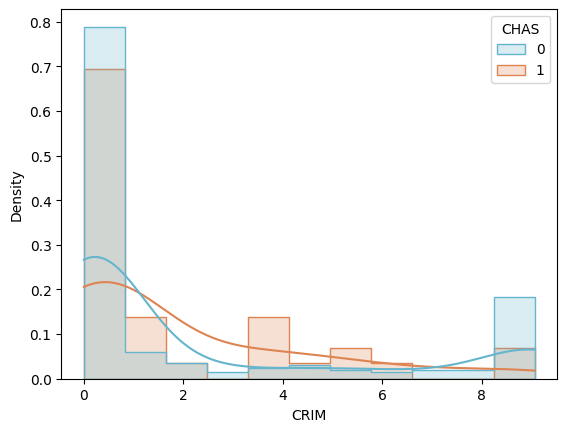

In [ ]:
# Use seaborn to create histograms and box plots for each group.
sns.histplot(
    data=boston_win,
    x='CRIM',
    hue='CHAS',
    kde=True,
    element='step',
    stat='density',
    common_norm=False,
)

plt.show()

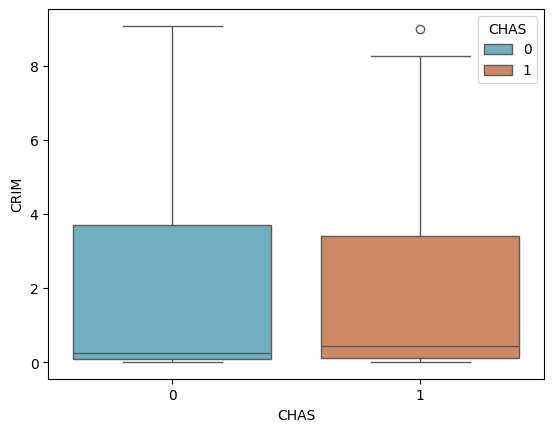

In [ ]:
sns.boxplot(x='CHAS', y='CRIM', data=boston_win, hue='CHAS')
plt.show()

In [ ]:
# Separate the CRIM data into two groups based on CHAS
crim_chas_0 = boston_win[boston_win['CHAS'] == 0]['CRIM']
crim_chas_1 = boston_win[boston_win['CHAS'] == 1]['CRIM']

# Perform a t-test
t_stat, p_value = ttest_ind(crim_chas_0, crim_chas_1, equal_var=False)

# Output the results
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 0.8929123738026279, P-value: 0.3767869249367304


A heatmap will give an overview of correlation coefficients. I have used absolute values so it is easier to read, however positive or negative slope will not be shown.


<Axes: >

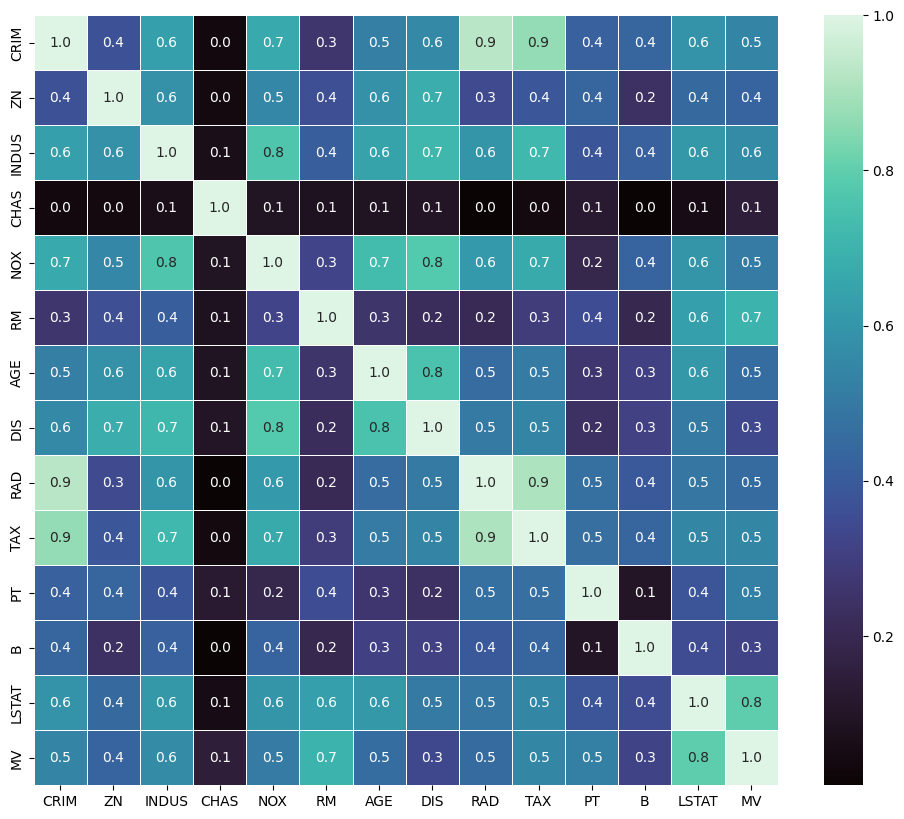

In [ ]:
plt.figure(figsize=(12, 10))

# Use absolute values to focus on correlation rather than slope direction.
corr_matrix = boston_win.corr().abs()
sns.heatmap(corr_matrix, annot=True, fmt='.1f', linewidth=0.5, cmap='mako')

Add pairplot for graph comparison with heatmap. Side by side, these are easier for a quick comparison.


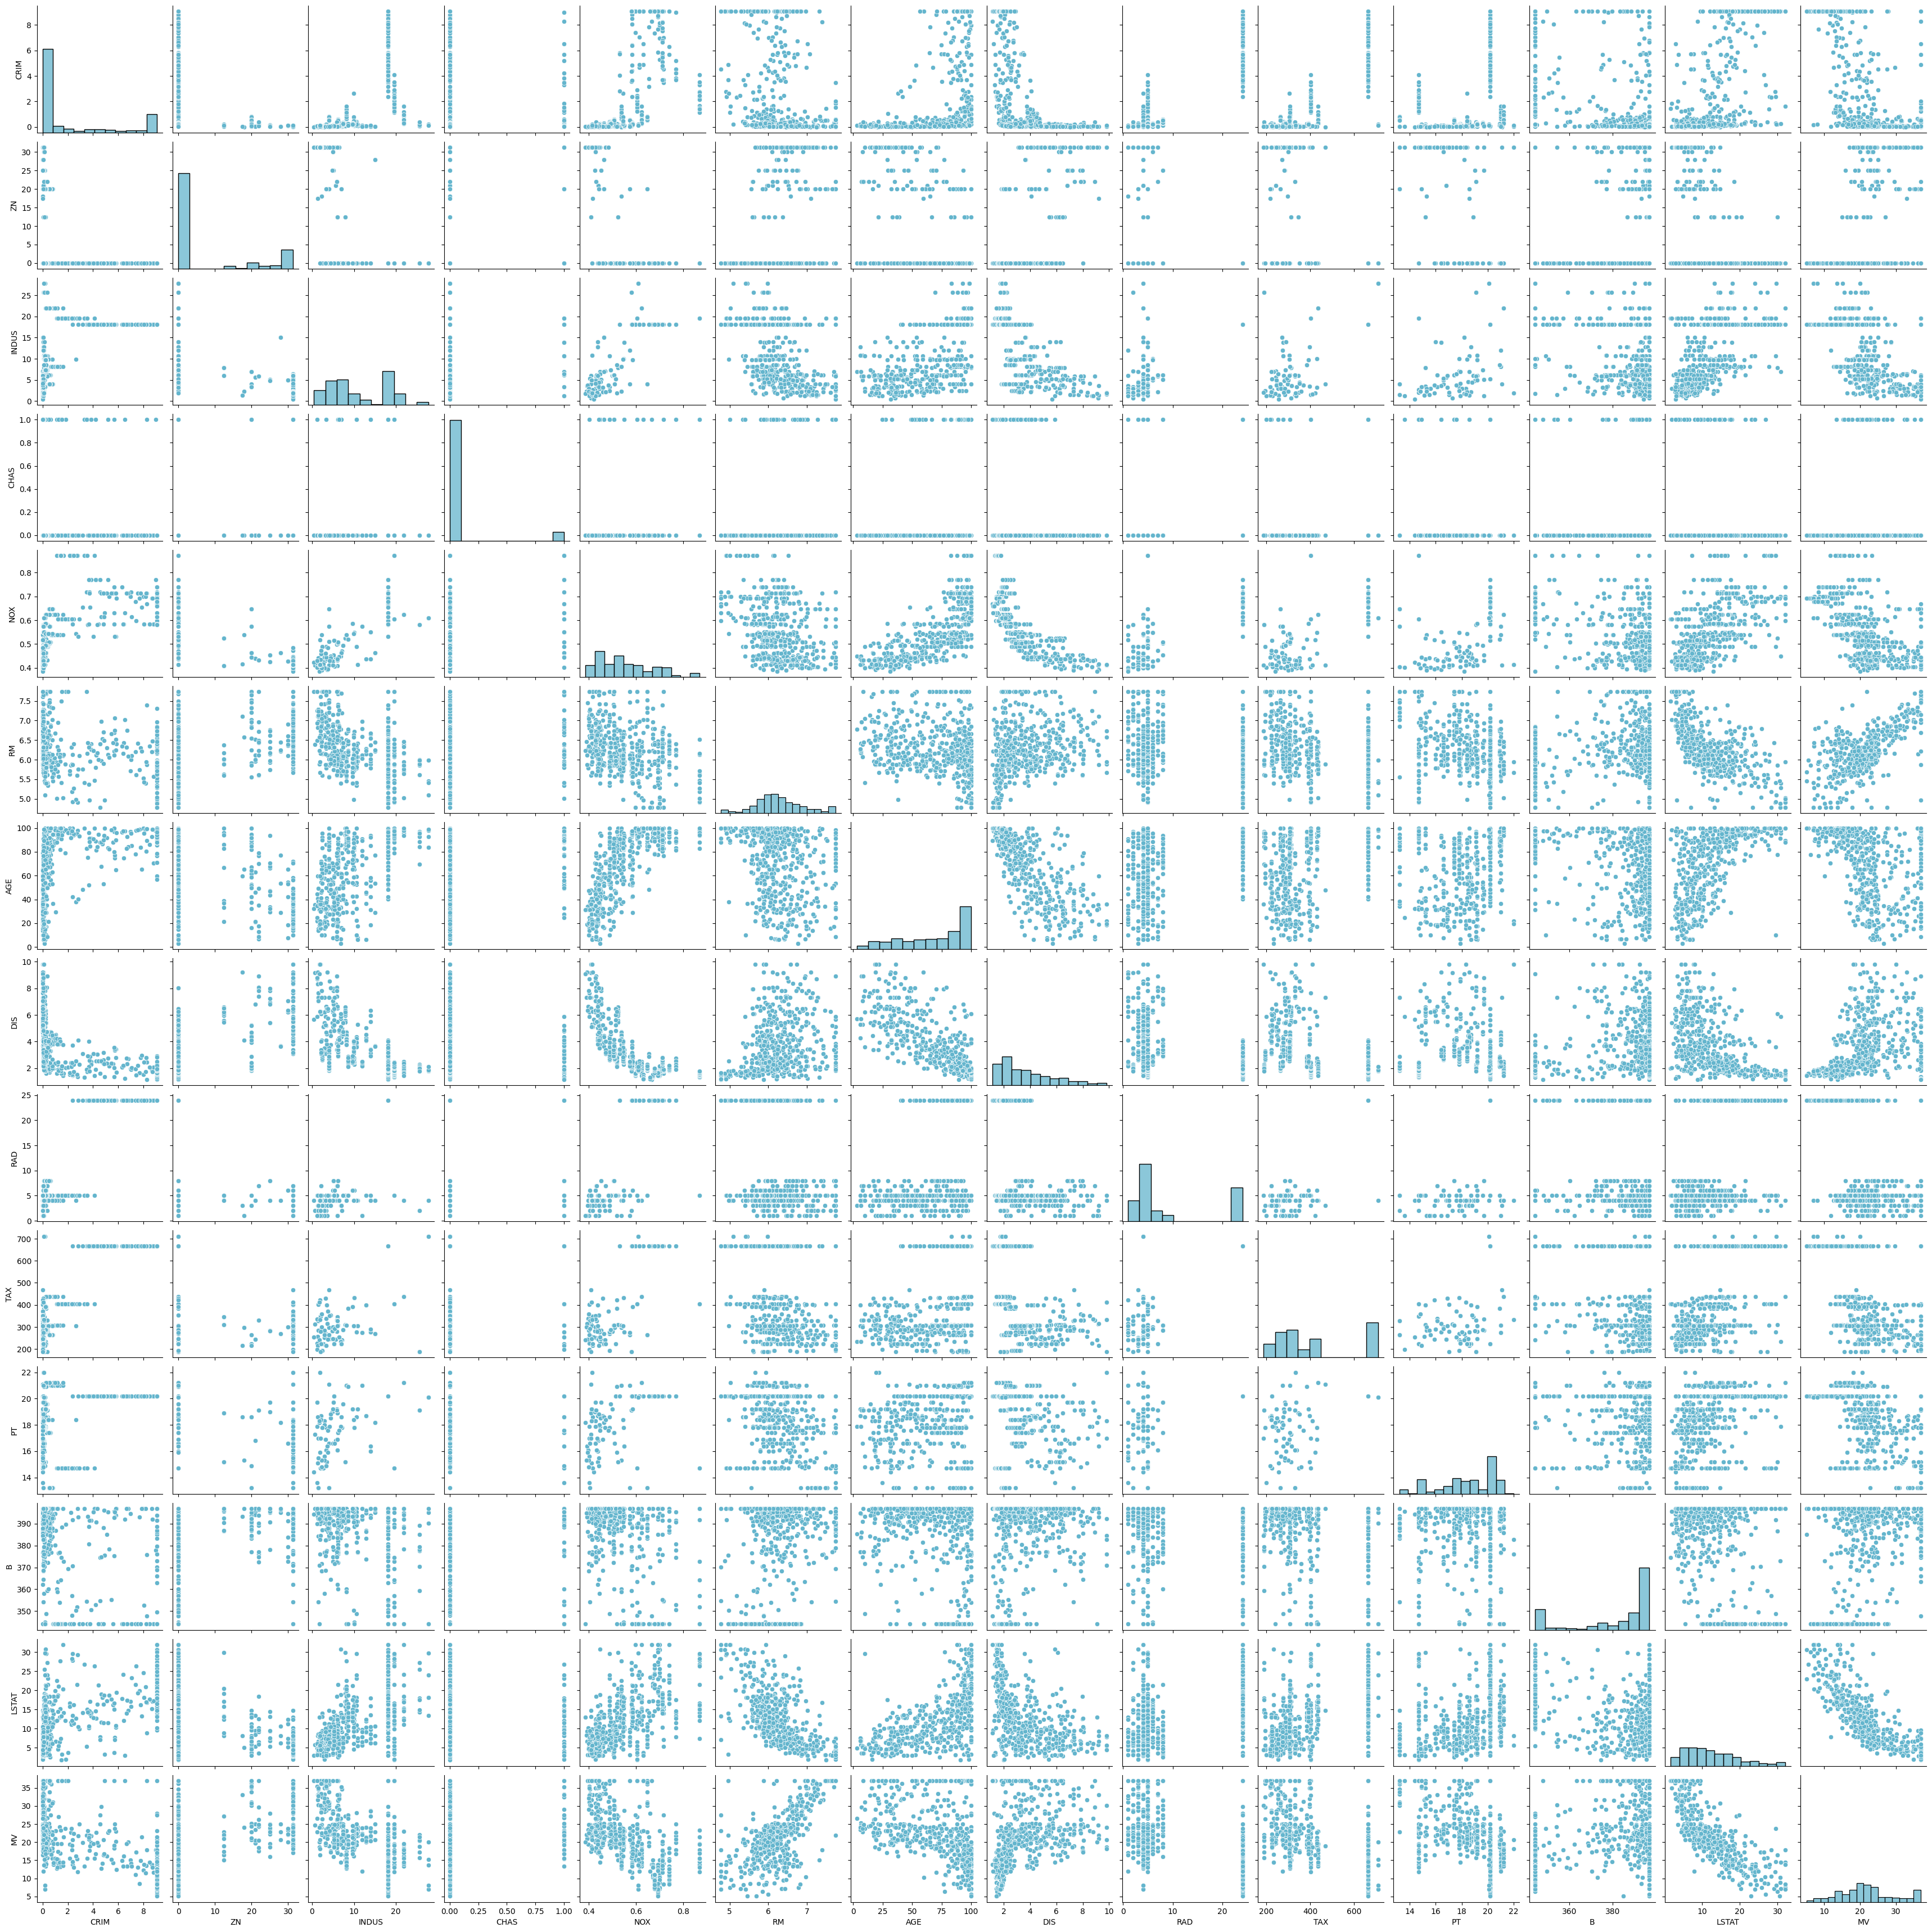

In [ ]:
sns.pairplot(boston_win)

Finally, generate scatter plots for comparing response (crime) tp the other predictors.


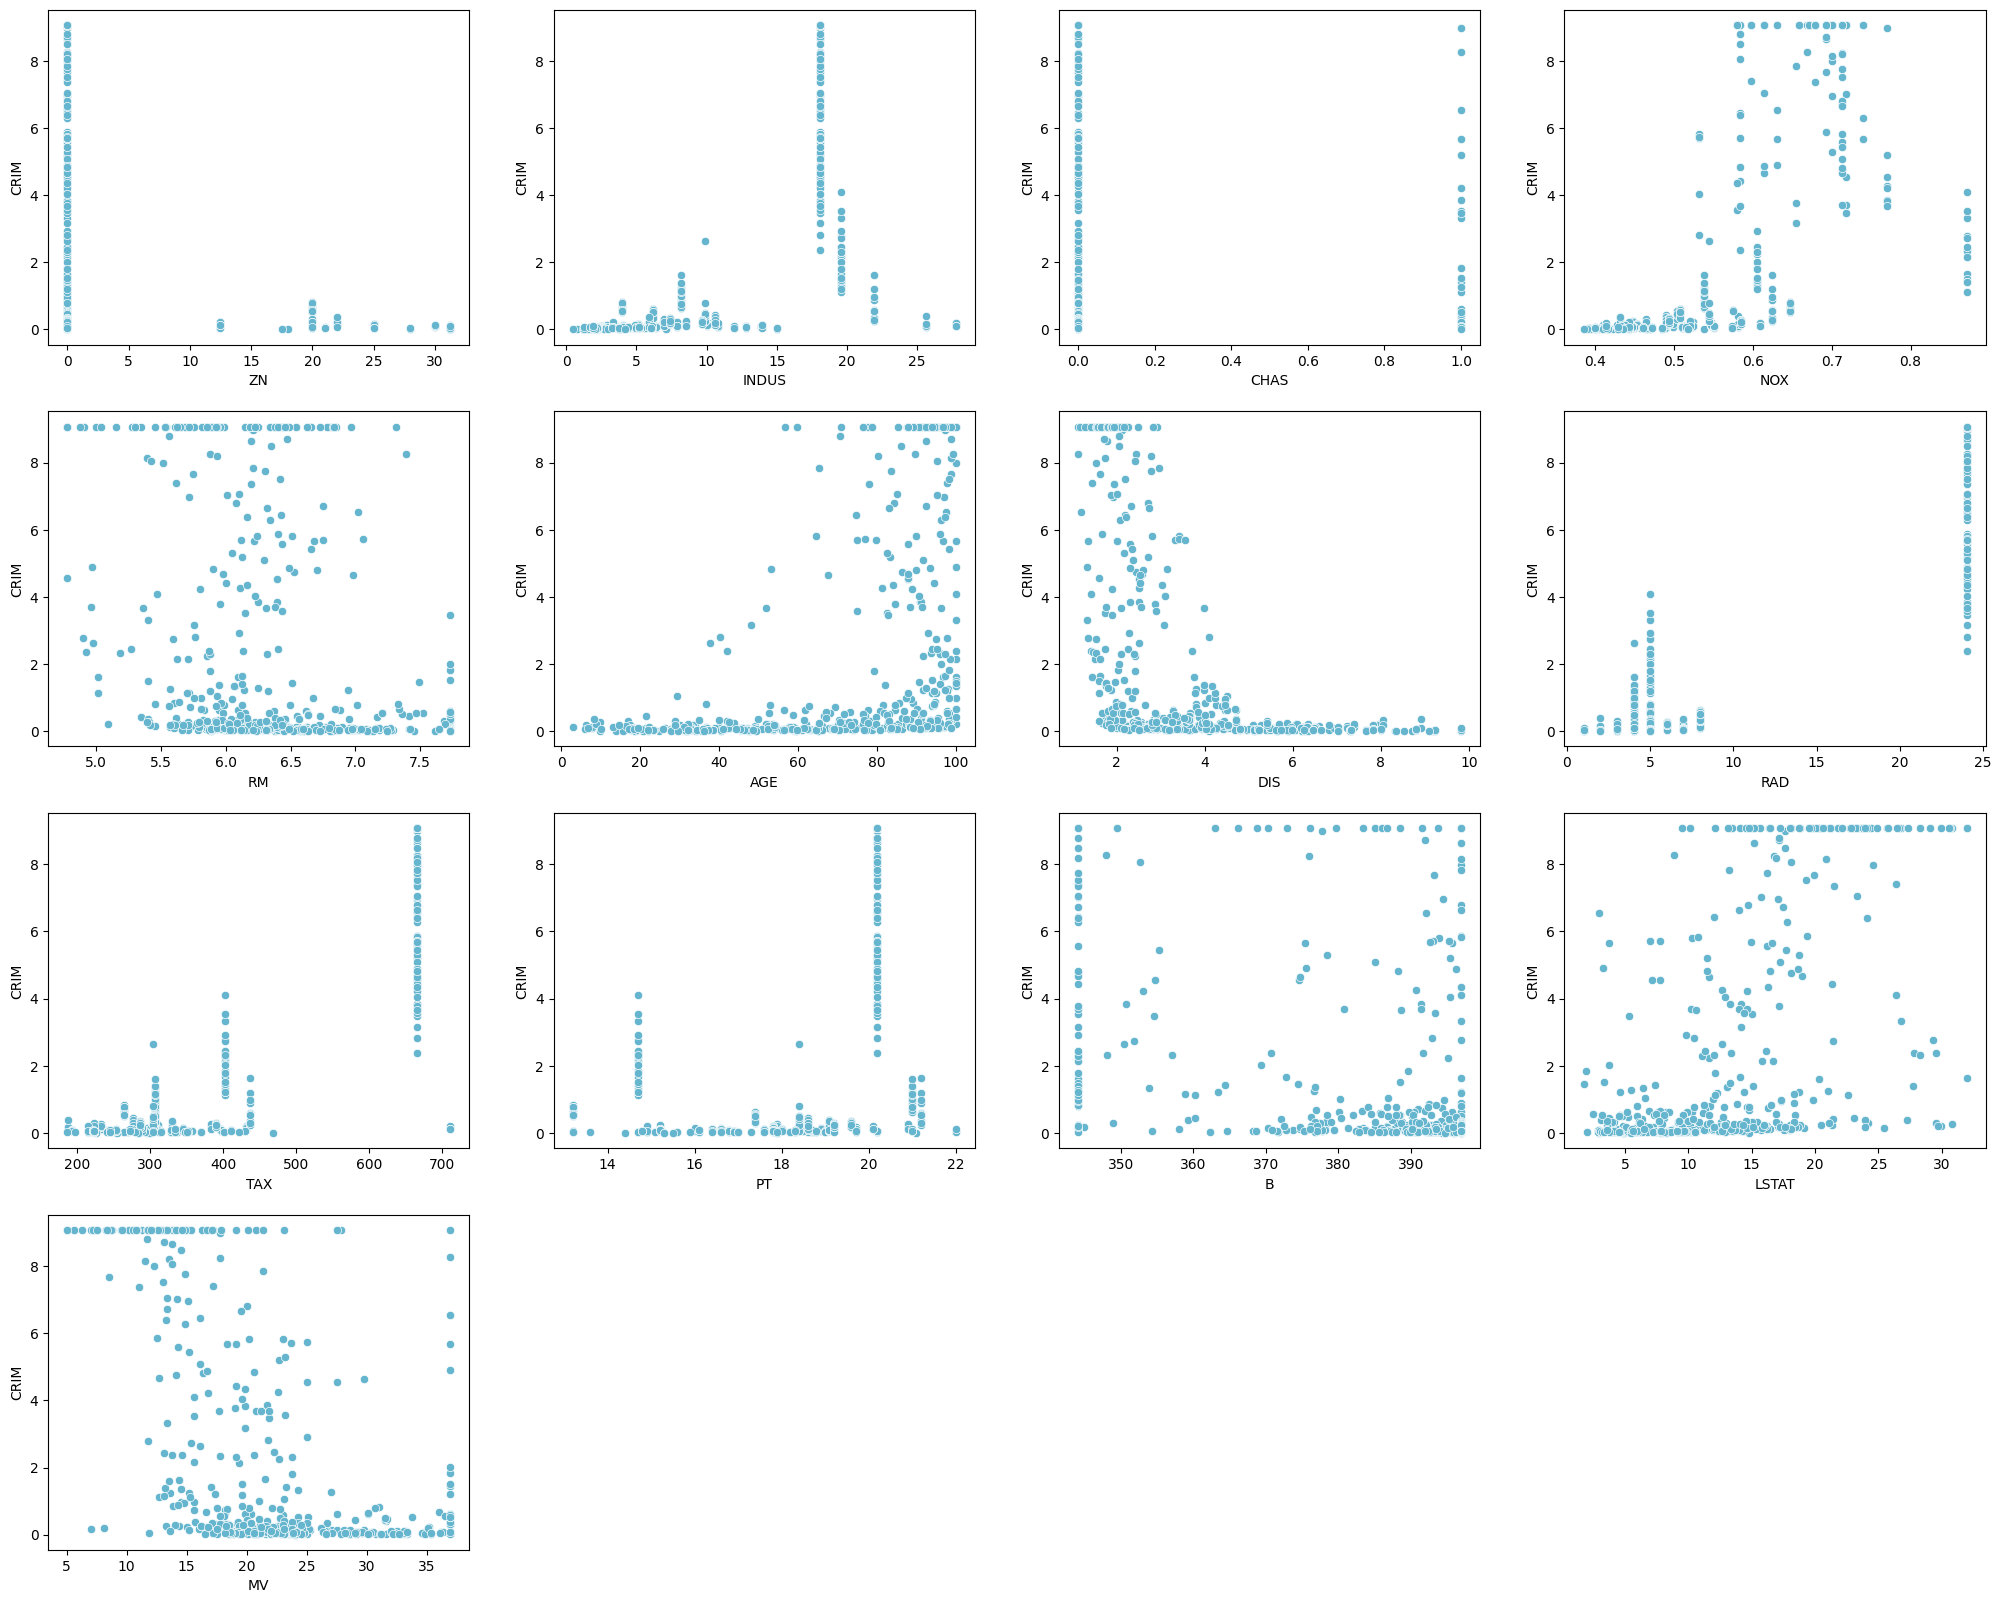

In [ ]:
multi_row_plot(sns.scatterplot, boston_win, y_col=True)

# Simple Linear regression

## b) For each predictor, fit a simple linear regression model to predict the response. Complete regression analysis. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create plots to back up your assertions.


First I will run a linear regression on each of the predictors to examine important values, such as rsquared, F-statistics, p-values, coefficients, etc. I will place them in a table for easy analysis. I will also examine residuals.


In [ ]:
# Initalise a results for an easily copyable table.
ols_results = []


def make_stats_table(
    data: object,
    pd_list: list,
    model: object,
    col: str,
) -> None:
    """Collect statistics for making a statistics table, used in a loop.

    Args:
        data (object): the datset as a DataFrame.
        pd_list (list): the list to append the data to.
        model (object): the model with the data.
        col (str): the column name.

    """
    # Access the Pearson CC Vlaues to add to the table
    crim_corr = data.corr()['CRIM'].drop('CRIM').abs()

    # Extract confidence intervals.
    conf_int = model.conf_int().loc[col]
    result = {
        'Predictor': col,
        'Pearson CC': crim_corr[col],
        'R-squared': model.rsquared,
        'MSE Residual': model.mse_resid,
        'Residual Std Err': model.mse_resid**0.5,
        'Coefficient': model.params[col],
        'Std Err': model.bse[col],
        'T-value': model.tvalues[col],
        'P-value': model.pvalues[col],
        'CI Lower': conf_int[0],
        'CI Upper': conf_int[1],
    }

    # Append results to create data frame later.
    pd_list.append(result)

In [ ]:
# Run the response against each predictor.
for col in boston_win.columns.drop('CRIM'):
    model = ols(f'CRIM ~ {col}', boston_win).fit()
    print(model.summary(), '\n')
    # Display stats for residuals.
    print(
        f'R**2 is {model.rsquared}\n'
        f'MSE Residual is {model.mse_resid}\n'
        f'Residual Standard error is {model.mse_resid**0.5}\n\n\n',
    )
    print(model.resid.describe())

    # collect stats ti make into a dataframe.
    make_stats_table(boston_win, ols_results, model, col)


                            OLS Regression Results                            
Dep. Variable:                   CRIM   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     80.05
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           6.99e-18
Time:                        21:49:50   Log-Likelihood:                -1286.4
No. Observations:                 506   AIC:                             2577.
Df Residuals:                     504   BIC:                             2585.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9351      0.158     18.542      0.0

In [ ]:
# Round the results in the list to three decimal points.
rounded_results = ols_results.copy()
for result in rounded_results:
    for key, value in result.items():
        if isinstance(value, (int, float)):
            result[key] = round(value, 3)

# Create a DataFrame from the results
results_df = pd.DataFrame(rounded_results)

results_df

Predictor  Pearson CC  R-squared  MSE Residual  Residual Std Err  \
0         ZN       0.370      0.137         9.492             3.081   
1      INDUS       0.629      0.396         6.644             2.578   
2       CHAS       0.031      0.001        10.990             3.315   
3        NOX       0.663      0.440         6.159             2.482   
4         RM       0.260      0.068        10.256             3.203   
5        AGE       0.519      0.269         8.038             2.835   
6        DIS       0.555      0.308         7.611             2.759   
7        RAD       0.927      0.859         1.548             1.244   
8        TAX       0.871      0.758         2.661             1.631   
9         PT       0.416      0.173         9.094             3.016   
10         B       0.436      0.190         8.908             2.985   
11     LSTAT       0.593      0.351         7.137             2.672   
12        MV       0.539      0.290         7.809             2.794   

    Coefficient  Std Err  T-value  P-value  CI Lower  CI Upper  
0        -0.102    0.011   -8.947     0.00    -0.124    -0.080  
1         0.304    0.017   18.179     0.00     0.271     0.337  
2        -0.401    0.581   -0.691     0.49    -1.542     0.740  
3        18.969    0.953   19.904     0.00    17.097    20.842  
4        -1.367    0.226   -6.046     0.00    -1.811    -0.923  
5         0.061    0.004   13.629     0.00     0.052     0.070  
6        -0.889    0.059  -14.980     0.00    -1.005    -0.772  
7         0.353    0.006   55.477     0.00     0.340     0.365  
8         0.017    0.000   39.742     0.00     0.016     0.018  
9         0.643    0.063   10.278     0.00     0.520     0.766  
10       -0.076    0.007  -10.881     0.00    -0.090    -0.062  
11        0.280    0.017   16.516     0.00     0.247     0.313  
12       -0.235    0.016  -14.351     0.00    -0.267    -0.203

Use seaborn regplot to do an automatic linear regression on each predictor for better visualisation.


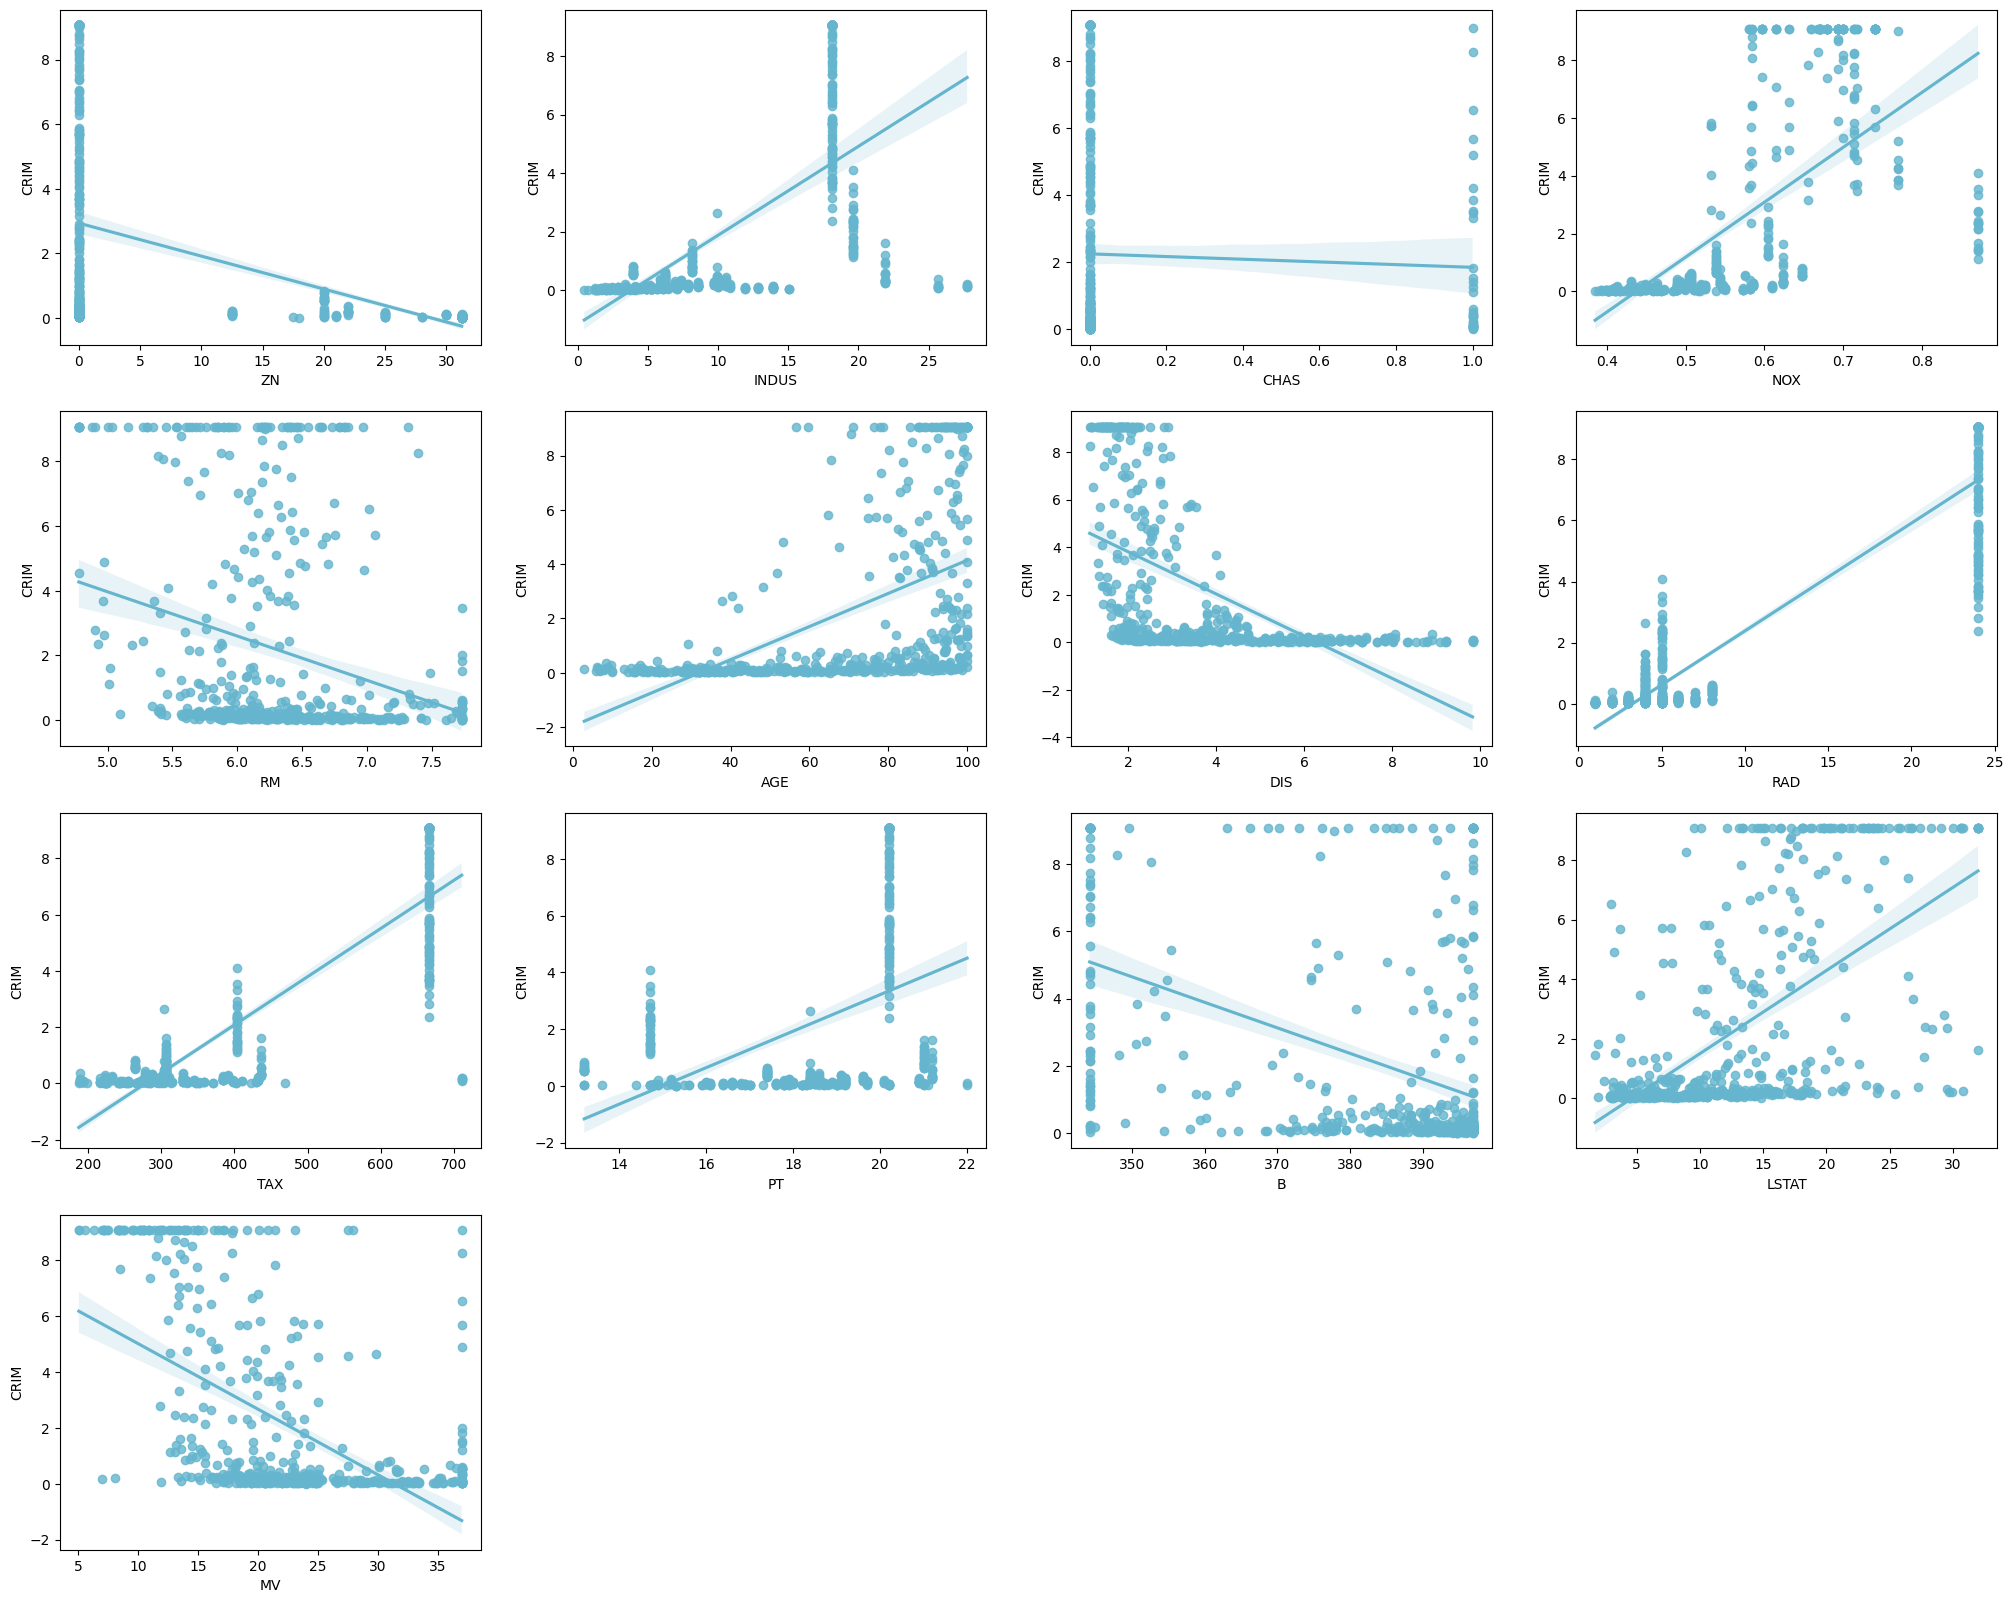

In [ ]:
multi_row_plot(sns.regplot, boston_win, y_col=True)

Examination of residual plots for linearity.


c:\Users\kenzedd\Documents\programming\data-analytics-dbs\statistics\ca1-boston-data\.venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


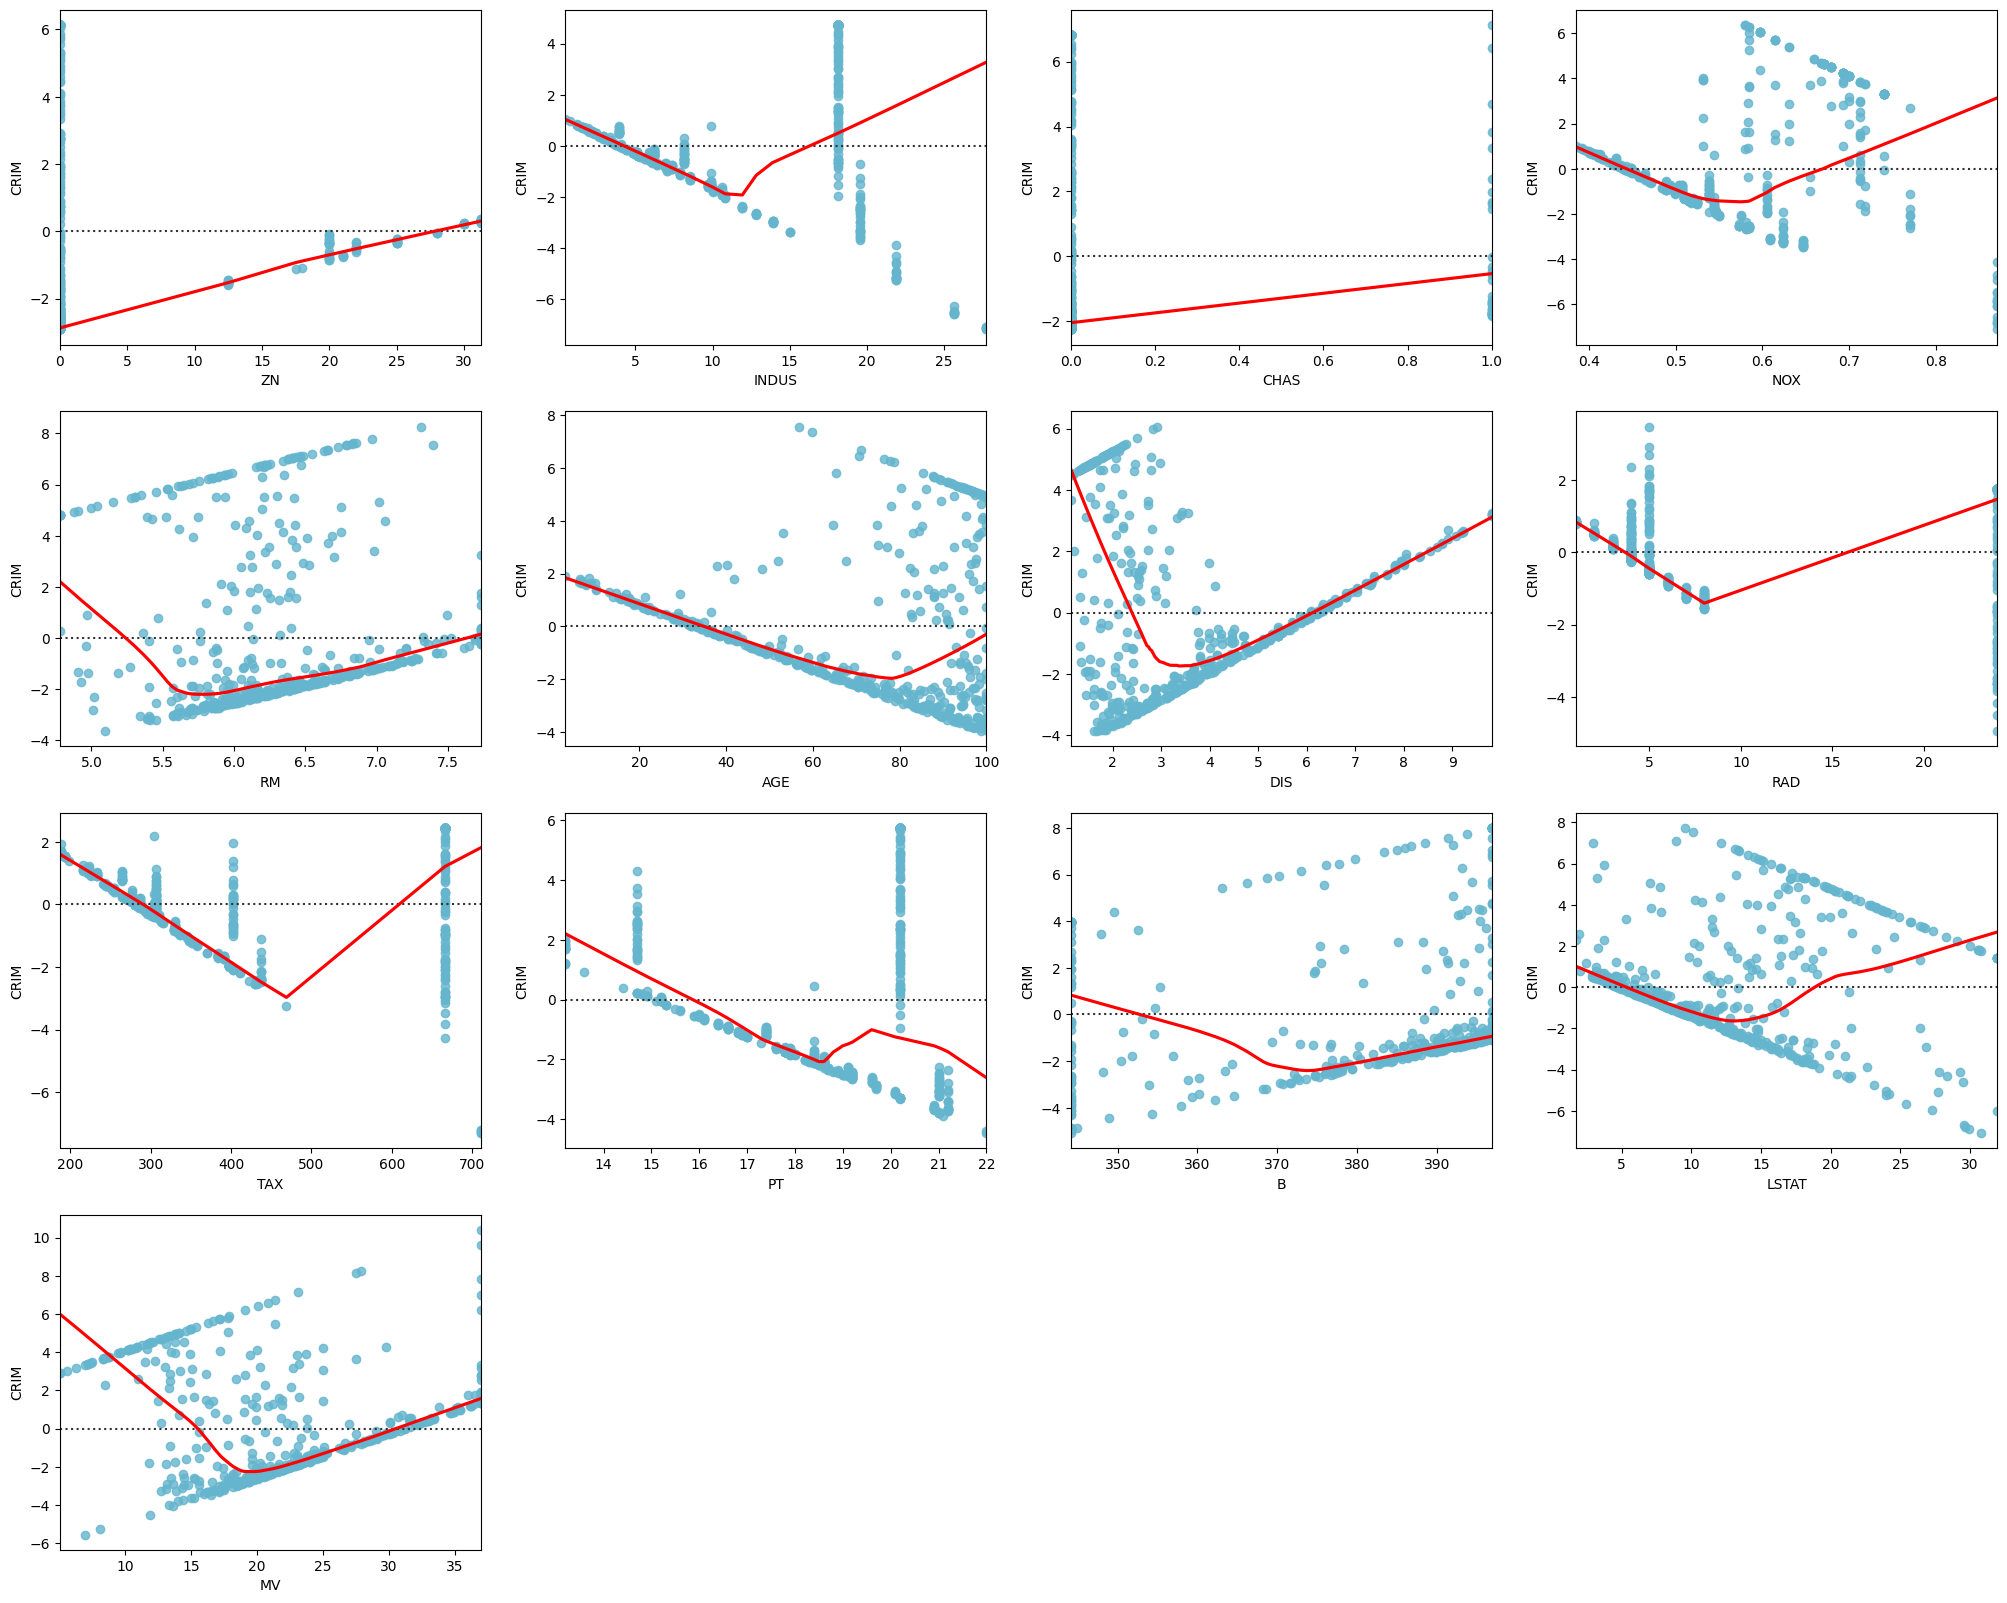

In [ ]:
multi_row_plot(
    sns.residplot,
    boston_win,
    y_col=True,
    lowess=True,
    line_kws={'color': 'r'},
)

# Multiple Linear Regression

## c) Fit a multiple regression model to predict the response using all the predictors. Describe your results. For which predictors can we reject the null hypothesis 𝐻₀ : 𝛽𝑗 = 0?


Create a model with all predictors.


In [ ]:
mlr_model = create_mlr_model(boston_win, ['CRIM'])
mlr_model.summary()

Residual Standard Error is  1.0755776221007618
Residual Standard Error is  1.0755776221007618


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     330.8
Date:                Sun, 08 Jun 2025   Prob (F-statistic):          1.88e-233
Time:                        22:17:05   Log-Likelihood:                -747.75
No. Observations:                 506   AIC:                             1524.
Df Residuals:                     492   BIC:                             1583.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2561      1.711      1.319      0.188      -1.105       5.617
ZN             0.0105      0.006      1.695      0.091      -0.002       0.023
INDUS         -0.0054      0.014     -0.384      0.701      -0.033       0.022
CHAS          -0.2718      0.196     -1.383      0.167      -0.658       0.114
NOX            0.4923      0.891      0.552      0.581      -1.258       2.243
RM             0.3423      0.115      2.986      0.003       0.117       0.568
AGE           -0.0019      0.003     -0.621      0.535      -0.008       0.004
DIS           -0.1671      0.049     -3.436      0.001      -0.263      -0.072
RAD            0.3063      0.015     21.060      0.000       0.278       0.335
TAX           -0.0001      0.001     -0.138      0.890      -0.002       0.002
PT            -0.0854      0.032     -2.641      0.009      -0.149      -0.022
B             -0.0064      0.003     -2.215      0.027      -0.012      -0.001
LSTAT          0.0556      0.014      4.079      0.000       0.029       0.082
MV            -0.0564      0.013     -4.196      0.000      -0.083      -0.030
==============================================================================
Omnibus:                       41.555   Durbin-Watson:                   0.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.917
Skew:                          -0.580   Prob(JB):                     1.32e-14
Kurtosis:                       4.298   Cond. No.                     2.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Plot the residuals to examine linearity.


Text(0, 0.5, 'Residuals')

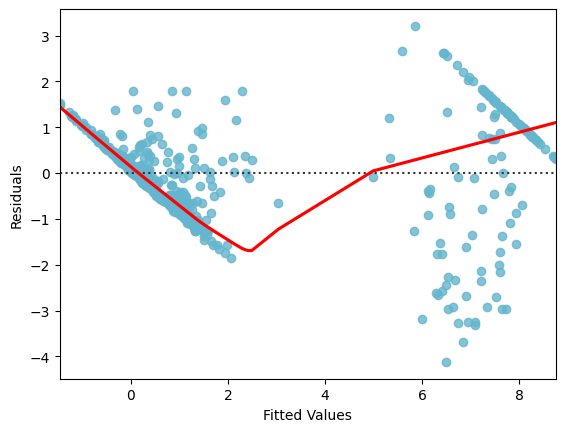

In [ ]:
sns.residplot(
    x=mlr_model.fittedvalues,
    y=mlr_model.resid,
    lowess=True,
    line_kws={'color': 'r'},
)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

Examine VIF scores to see degree of impact on mutlicollinearity.


In [ ]:
# Drop CRIM from predictors.
vif_predictors = boston_win.drop(columns=['CRIM'])

boston_vif = pd.DataFrame()

# Structure the data into a DataFrame, rounding the VIF scores.
boston_vif['predictor'] = vif_predictors.columns
boston_vif['VIF Score'] = [
    round(variance_inflation_factor(vif_predictors.values, i), 3)
    for i in range(vif_predictors.shape[1])
]

boston_vif

predictor  VIF Score
0         ZN      3.254
1      INDUS     14.613
2       CHAS      1.168
3        NOX     85.943
4         RM    193.522
5        AGE     21.582
6        DIS     16.846
7        RAD     14.581
8        TAX     59.701
9         PT    131.482
10         B    311.003
11     LSTAT     14.565
12        MV     39.209

Create a model that doesn't include items of high VIF scores.


In [ ]:
novif_mlr_model = create_mlr_model(boston_win, ['CRIM', 'B', 'PT', 'RM'])
novif_mlr_model.summary()

Residual Standard Error is  1.0978165749404953


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     410.5
Date:                Sun, 08 Jun 2025   Prob (F-statistic):          2.48e-232
Time:                        22:18:11   Log-Likelihood:                -759.64
No. Observations:                 506   AIC:                             1541.
Df Residuals:                     495   BIC:                             1588.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8720      0.755     -1.155      0.249      -2.356       0.612
ZN             0.0181      0.006      3.035      0.003       0.006       0.030
INDUS         -0.0108      0.014     -0.767      0.444      -0.038       0.017
CHAS          -0.2594      0.200     -1.296      0.196      -0.653       0.134
NOX            1.6373      0.839      1.952      0.052      -0.011       3.285
AGE           -0.0007      0.003     -0.233      0.816      -0.007       0.005
DIS           -0.1647      0.050     -3.324      0.001      -0.262      -0.067
RAD            0.3016      0.014     21.140      0.000       0.274       0.330
TAX         4.712e-05      0.001      0.055      0.956      -0.002       0.002
LSTAT          0.0508      0.013      3.837      0.000       0.025       0.077
MV            -0.0305      0.012     -2.526      0.012      -0.054      -0.007
==============================================================================
Omnibus:                       40.481   Durbin-Watson:                   0.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.192
Skew:                          -0.608   Prob(JB):                     6.28e-13
Kurtosis:                       4.089   Cond. No.                     9.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Create a model that only contains statistically significant predictors.

In [ ]:
sig_model = create_mlr_model(
    boston_win, ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'TAX'],
)
sig_model.summary()

Residual Standard Error is  1.0757167600053223


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     613.3
Date:                Sun, 08 Jun 2025   Prob (F-statistic):          3.47e-240
Time:                        22:18:50   Log-Likelihood:                -750.88
No. Observations:                 506   AIC:                             1518.
Df Residuals:                     498   BIC:                             1552.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2651      1.394      1.625      0.105      -0.474       5.004
RM             0.3600      0.111      3.244      0.001       0.142       0.578
DIS           -0.1125      0.029     -3.874      0.000      -0.170      -0.055
RAD            0.3080      0.008     40.620      0.000       0.293       0.323
PT            -0.1063      0.028     -3.740      0.000      -0.162      -0.050
B             -0.0060      0.003     -2.117      0.035      -0.012      -0.000
LSTAT          0.0544      0.013      4.187      0.000       0.029       0.080
MV            -0.0565      0.013     -4.492      0.000      -0.081      -0.032
==============================================================================
Omnibus:                       45.048   Durbin-Watson:                   0.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.715
Skew:                          -0.617   Prob(JB):                     7.27e-16
Kurtosis:                       4.335   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Create a model with statistically significant predictors without high-VIF predictor B.

In [ ]:
nob_sig_model = create_mlr_model(
    boston_win, ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'TAX', 'B'],
)
nob_sig_model.summary()

Residual Standard Error is  1.0794634573485482


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     709.8
Date:                Sun, 08 Jun 2025   Prob (F-statistic):          1.16e-240
Time:                        22:21:01   Log-Likelihood:                -753.15
No. Observations:                 506   AIC:                             1520.
Df Residuals:                     499   BIC:                             1550.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2008      1.000      0.201      0.841      -1.763       2.165
RM             0.3598      0.111      3.231      0.001       0.141       0.579
DIS           -0.1184      0.029     -4.082      0.000      -0.175      -0.061
RAD            0.3121      0.007     42.452      0.000       0.298       0.327
PT            -0.1170      0.028     -4.169      0.000      -0.172      -0.062
LSTAT          0.0553      0.013      4.245      0.000       0.030       0.081
MV            -0.0596      0.013     -4.751      0.000      -0.084      -0.035
==============================================================================
Omnibus:                       39.033   Durbin-Watson:                   0.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.711
Skew:                          -0.559   Prob(JB):                     1.78e-13
Kurtosis:                       4.238   Cond. No.                         705.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Coefficient comparions
## d) How do your results from (b) compare to your results from (c)? Create a plot displaying the univariate regression coefficients from (b) on the x-axis, and the multiple regression coefficients from (c) on the y-axis. That is each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.


Create a DataFrame from our previously collected results to plot.

In [ ]:

# Collect stats from our results and MLR model to plot.
coefficient_df = pd.DataFrame(
    {
        'Predictor': [result['Predictor'] for result in ols_results],
        'Uni Coefficient': [result['Coefficient'] for result in ols_results],
        'Multi Coefficient': list(mlr_model.params[1:]),
    },
)

# Check the stats are correct.
coefficient_df

Predictor  Uni Coefficient  Multi Coefficient
0         ZN           -0.102           0.010527
1      INDUS            0.304          -0.005367
2       CHAS           -0.401          -0.271784
3        NOX           18.969           0.492269
4         RM           -1.367           0.342292
5        AGE            0.061          -0.001864
6        DIS           -0.889          -0.167078
7        RAD            0.353           0.306344
8        TAX            0.017          -0.000117
9         PT            0.643          -0.085431
10         B           -0.076          -0.006425
11     LSTAT            0.280           0.055558
12        MV           -0.235          -0.056413

<Axes: xlabel='Uni Coefficient', ylabel='Multi Coefficient'>

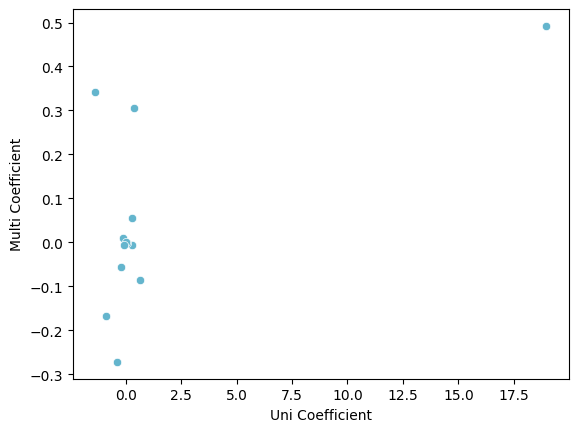

In [ ]:
sns.scatterplot(
    data=coefficient_df,
    x='Uni Coefficient',
    y='Multi Coefficient',
)

Create a grid without NOX for more clarity.

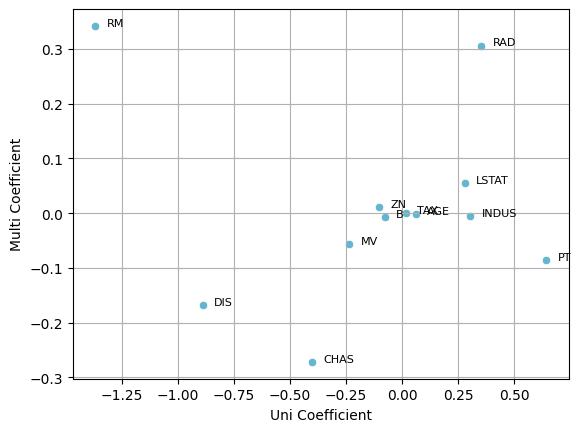

In [ ]:
# Remove NOX
filtered_df = coefficient_df[coefficient_df['Predictor'] != 'NOX']


sns.scatterplot(
    data=filtered_df,
    x='Uni Coefficient',
    y='Multi Coefficient',
)
# Label each item
for i, row in filtered_df.iterrows():
    plt.text(row['Uni Coefficient'] + 0.05, row['Multi Coefficient'], row['Predictor'], fontsize=8)

plt.xlabel('Uni Coefficient')
plt.ylabel('Multi Coefficient')
plt.grid(True)


# Non-linear relationships
## e) Is there evidence of non-linear association between any of the predictors and the response?To answer this question, for each predictor X, fit a model of the form 𝑌 = 𝛽0+𝛽1 𝑋 + 𝛽2𝑋²+𝛽3𝑋³+ Ԑ Summarise your findings.

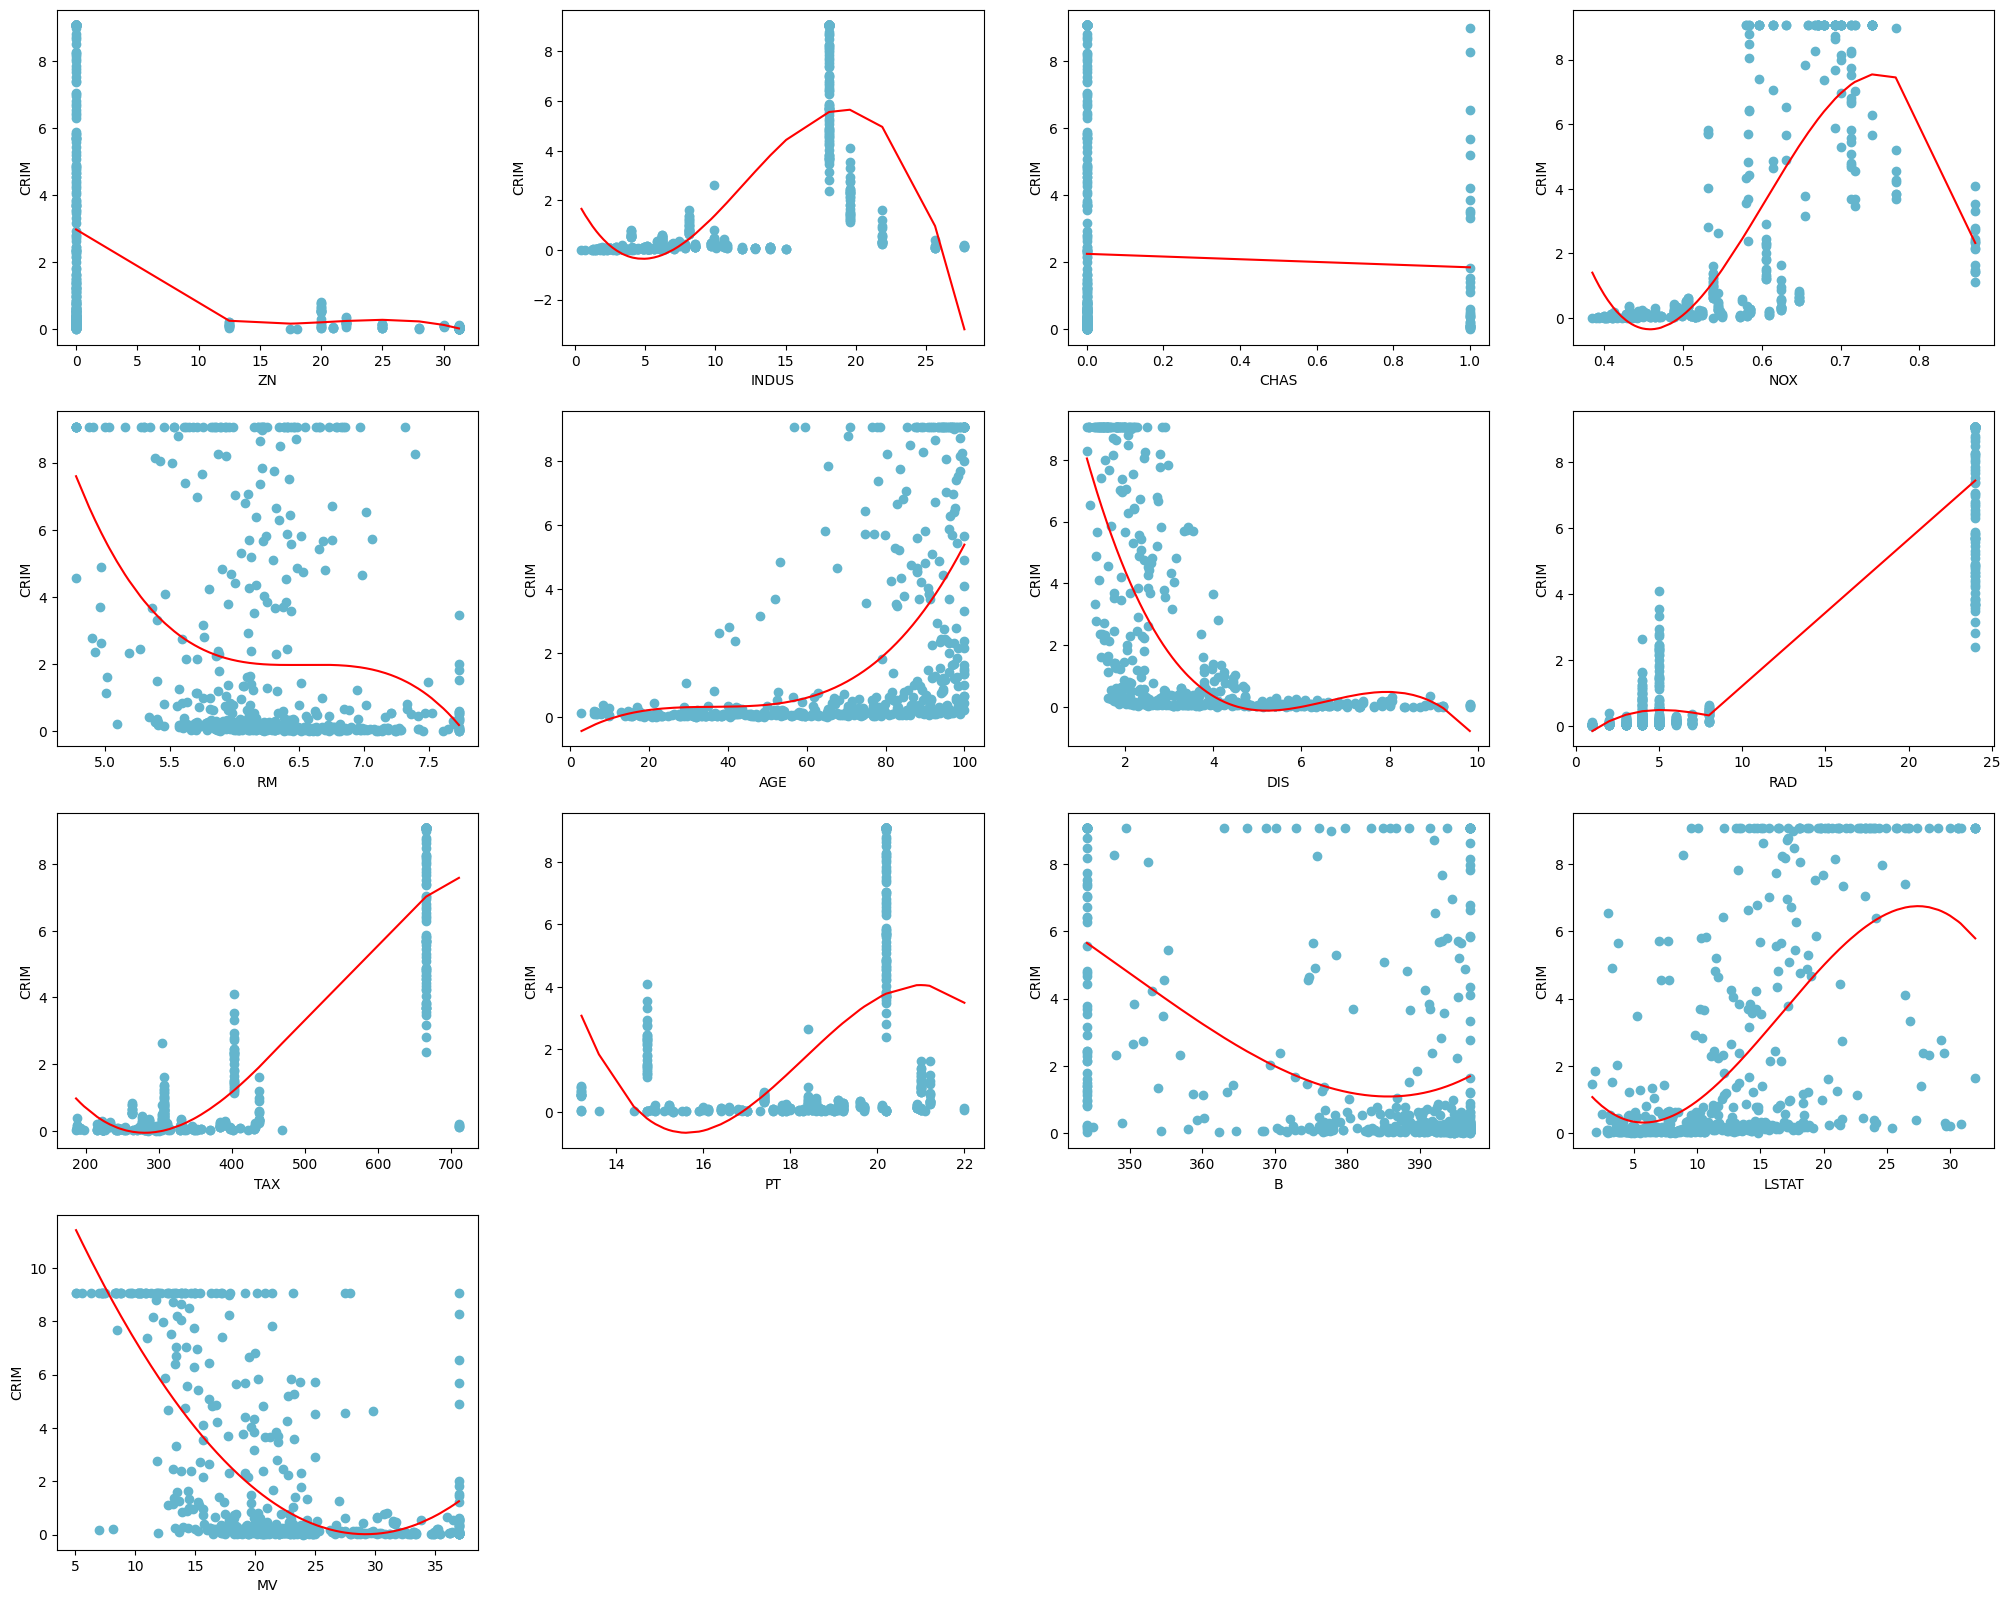

In [ ]:
# Initalise variable for table creation.
p_list = []
r_list = []
ar_list = []
pv_list = []
f_list = []
# Initalise DataFrame
poly_stats_df = pd.DataFrame(
    {
        'Predictor': p_list,
        'R-squared': r_list,
        'Adj r-squared': ar_list,
        'P-value': pv_list,
        'F-statistic': f_list,
    },
)

#Create plots for polynomial regression
fig_plot, axes = plt.subplots(4, 4, figsize=(25, 20))
axes = axes.flatten()
for i, col in enumerate(boston_win.columns.drop('CRIM')):
    x = boston_win[col].to_numpy()
    y = boston_win['CRIM'].to_numpy()


    inds = x.ravel().argsort()  # Sort x values and get index
    x = x.ravel()[inds].reshape(-1, 1)
    y = y[inds]  # Sort y according to x sorted index

    polynomial_features = PolynomialFeatures(degree=3)
    xp = polynomial_features.fit_transform(x)

    model = OLS(y, xp).fit()

    ypred = model.predict(xp)

    axes[i].scatter(x, y)
    axes[i].plot(x, ypred, color='red')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('CRIM')
    
    # Append values to the lists
    p_list.append(col)
    r_list.append(round(model.rsquared, 3)) 
    ar_list.append(round(model.rsquared_adj, 3))
    pv_list.append(round(model.f_pvalue, 3))
    f_list.append(round(model.fvalue, 3))

# Remove unused plots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add values to DataFrame
poly_stats_df['Predictor'] = p_list
poly_stats_df['R-squared'] = r_list
poly_stats_df['Adj r-squared'] = ar_list
poly_stats_df['P-value'] = pv_list
poly_stats_df['F-statistic'] = f_list


In [ ]:
poly_stats_df

Predictor  R-squared  Adj r-squared  P-value  F-statistic
0         ZN      0.144          0.139     0.00       28.257
1      INDUS      0.611          0.609     0.00      262.805
2       CHAS      0.001         -0.001     0.49        0.477
3        NOX      0.644          0.642     0.00      302.974
4         RM      0.106          0.101     0.00       19.944
5        AGE      0.333          0.329     0.00       83.671
6        DIS      0.478          0.475     0.00      153.405
7        RAD      0.877          0.876     0.00     1188.197
8        TAX      0.812          0.811     0.00      721.273
9         PT      0.254          0.250     0.00       57.009
10         B      0.227          0.223     0.00       49.274
11     LSTAT      0.380          0.376     0.00      102.626
12        MV      0.471          0.467     0.00      148.733

Examine DIS residual anlaysis.

Text(0.5, 1.0, 'DIS')

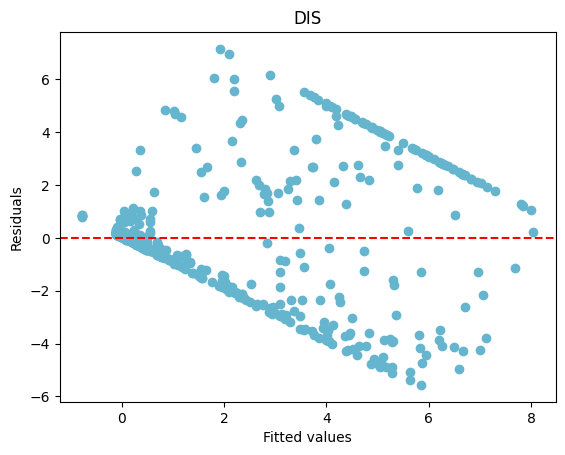

In [ ]:
# Select x and y values.
x = boston_win['DIS'].to_numpy()
y = boston_win['CRIM'].to_numpy()

inds = x.ravel().argsort()  # Sort x values and get index.
x = x.ravel()[inds].reshape(-1, 1)
y = y[inds]  # Sort y according to x sorted index.

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(x)

model = OLS(y, xp).fit()
ypred = model.predict(xp)

# Calculate the residuals.
residuals = y - model.predict(xp)
# Plot the residuals.
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.scatter(model.predict(xp), residuals)
plt.ylabel('Residuals')
plt.title('DIS')

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     153.4
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           1.48e-70
Time:                        21:32:42   Log-Likelihood:                -1159.0
No. Observations:                 506   AIC:                             2326.
Df Residuals:                     502   BIC:                             2343.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0128      0.944     15.906      0.000      13.158      16.867
x1            -7.4290      0.718    -10.349      0.000      -8.839      -6.019
x2             1.1804      0.156      7.573      0.000       0.874       1.487
x3            -0.0598      0.010     -5.952      0.000      -0.080      -0.040
==============================================================================
Omnibus:                        6.722   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.577
Skew:                           0.271   Prob(JB):                       0.0373
Kurtosis:                       3.131   Cond. No.                     2.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Compare to original data residuals.

Text(0.5, 1.0, 'DIS')

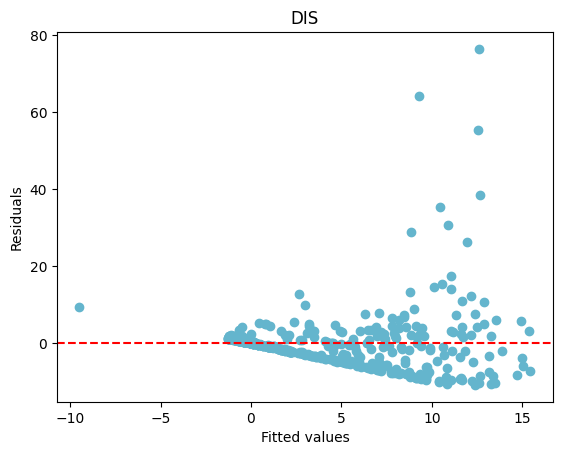

In [ ]:
# Select x and y values.

x = boston_csv['DIS'].to_numpy()
y = boston_csv['CRIM'].to_numpy()

inds = x.ravel().argsort()  # Sort x values and get index
x = x.ravel()[inds].reshape(-1, 1)
y = y[inds]  # Sort y according to x sorted index

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(x)

model = OLS(y, xp).fit()
ypred = model.predict(xp)
# Calculate the residuals.
residuals = y - model.predict(xp)

# Plot the residuals.
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.scatter(model.predict(xp), residuals)
plt.ylabel('Residuals')
plt.title('DIS')